# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#00917C; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> 2603376 Knowledge Discovery and Data Mining</p>

# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#00917C; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> Condo Price Prediction </p>

    The popularity of condominiums as a first home among people in Bangkok is increasing due to their preference for a convenient lifestyle. When making a decision to purchase, buyers consider the price of the condominium as a key factor. Therefore, the goal of this study is to create a model that can predict the selling price of a condominium in Bangkok. The purpose of this model is to assist buyers in their decision-making process by providing them with predicted prices.

<br>
<center><img src="https://cdn-images.prod.thinkofliving.com/wp-content/uploads/1/2019/08/06103238/S__152125772.jpg" width="800px"></center>

# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#00917C; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> This project is brought to you by </p>

* Kornkanok Klinsumalee (6341005826)
* Noppakrit Phurisuriyaroj (6341109426)
* Goman Kliaokanokphan (6341017326)
* Suramate Chokchaisuwan (6341232926)
* Dhawalrat Leelapratak (6341096926)


# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#035956; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> Outline </p>

1. Import dataset and libraries

    * 1.1 Data Cleaning
    
    * 1.2 Terminology of features and variables ที่ถูกใช้ในการทำ Model
2. EDA

    * 2.1 Data summary
    
    * 2.2 Barplot Price by Sub-district
    * 2.3 Pointplot Price Distribution for Sub-district
    * 2.4 Histogram plot
    * 2.5 Pairplot
3. Data preparation

    * 3.1 โดยกำหนด LabelEncoder ( เป็น order )
    
    * 3.2 Change categorical column to one-hot encoding
4. Models
    * 4.1 Spilt train test
    
    * 4.2 Create and Find best Models
    * 4.3 Feature Important
    * 4.4 Compare Predicts vs Actual
    * 4.5 Create Model
        * 4.5.1 LightGBM Regressor

        * 4.5.2 XGBoost Regressor 
        * 4.5.3 Catboost Regressor
        
5. Feature and Model Evaluation
6. Prediction
7. Referance


<a id="import-libraries"></a>
# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#00917C; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> 1. Import dataset and libraries</p>

In [1]:
import re
import os
import csv
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
from ipywidgets import interact
import seaborn as sns
plt.rcParams['font.family'] = 'Tahoma'

กลุ่มของนิสิตได้ทำการ Scraping ข้อมูลมาจาก Website DDProperty* ซึ่งมีการรวบรวมข้อมูลของคอนโดที่มีการประกาศขายอยู่บน Website ในหลายเขต ได้แก่
1. เขตสาทร
2. เขตปทุมวัน
3. เขตบางคอแหลม
4. เขตบางรัก
5. เขตคลองสาน
6. เขตธนบุรี
7. เขตยานนาวา

ผลลัพธ์ของการ scraping จะออกมาในรูปแบบของไฟล์ .csv (comma separated values) จึงได้มีการรวมข้อมูลให้อยู่ใน DataFrame เดียวกัน


In [2]:
def get_data(path):
    dir_path = path
    for filename in os.listdir(dir_path):
        if filename.endswith('.csv'):
            with open(os.path.join(dir_path, filename)) as csvfile:
                data = list(csv.reader(csvfile))
            yield data

def create_dataframe(data):
    for d in data:
        try:
            df = pd.DataFrame(d[1:], columns=d[0])
            yield df
        except Exception as e:
            print(f"Error creating DataFrame: {e}")

data = get_data('data/')
df_list = list(create_dataframe(data))
df = reduce(lambda df1,df2: pd.merge(df1,df2,how ='outer'), df_list)
df = df.iloc[:, 5:]

In [3]:
def clean_space(df, columns: dict):
    df_copy = df.copy()
    for column in columns:
            df_copy[column] = df_copy[column].astype(str)
            df_copy[column] = df_copy[column].str.replace('\n', '').str.strip()
            df_copy[column] = df_copy[column].apply(lambda x: re.sub(r'\s{2,}', columns[column], x))
            yield column, df_copy[column]

def replace_column_data(df, columns_data: dict):
    df_replaced = df.copy()
    for key in columns_data.keys():
        df_replaced[key] = columns_data[key]
    return df_replaced

clean_columns = dict(clean_space(df, {"facility": ',', "space": ' '}))
df = replace_column_data(df, clean_columns)

In [4]:
df.head()

,name,price,Province,area (keat),district,bedroom,bathroom,space,year,type,furniture,station,floor,facility
0,"Supalai Casa Riva : ศุภาลัย คาซา ริวา, กรุงเทพ","17,500,000",กรุงเทพ,บางคอแหลม,บางคอแหลม,3,3,240 ตร.ม.,"December, 2006",ขายขาด,null,สถานีใกล้เคียง10 นาที (720 ม.) ถึง B11 BRT สะพ...,null,"สิ่งอำนวยความสะดวก & สถานที่ใกล้เคียง,สิ่งอำนว..."
1,"Supalai Casa Riva : ศุภาลัย คาซา ริวา, กรุงเทพ","19,000,000",กรุงเทพ,บางคอแหลม,บางคอแหลม,3,3,230 ตร.ม.,"December, 2006",ขายขาด,null,สถานีใกล้เคียง10 นาที (720 ม.) ถึง B11 BRT สะพ...,null,"สิ่งอำนวยความสะดวก & สถานที่ใกล้เคียง,สิ่งอำนว..."
2,Lumpini Place Rama 3 - Riverview : ลุมพินี เพล...,"2,500,000",กรุงเทพ,บางคอแหลม,บางโคล่,1,1,39 ตร.ม.,"December, 2004",null,null,สถานีใกล้เคียง2 นาที (150 ม.) ถึง B10 BRT เจริ...,null,"สิ่งอำนวยความสะดวก & สถานที่ใกล้เคียง,สิ่งอำนว..."
3,Lumpini Place Rama 3 - Riverview : ลุมพินี เพล...,"3,100,000",กรุงเทพ,บางคอแหลม,บางโคล่,1,1,40 ตร.ม.,"December, 2004",null,null,สถานีใกล้เคียง2 นาที (150 ม.) ถึง B10 BRT เจริ...,null,"สิ่งอำนวยความสะดวก & สถานที่ใกล้เคียง,สิ่งอำนว..."
4,Lumpini Place Rama 3 - Riverview : ลุมพินี เพล...,"28,500,000",กรุงเทพ,บางคอแหลม,บางโคล่,1,1,39 ตร.ม.,"December, 2004",null,null,สถานีใกล้เคียง2 นาที (150 ม.) ถึง B10 BRT เจริ...,null,"สิ่งอำนวยความสะดวก & สถานที่ใกล้เคียง,สิ่งอำนว..."


<a id="2"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid"> 1.1 Data Cleaning</p>

เนื่องจากข้อมูลที่ได้จากการ scrape นั้น มีข้อมูลที่หลากหลาย เนื่องจากมี format ที่ไม่ตายตัวและอนุญาตให้คนขายสามารถป้อนเนื้อความได้อย่างอิสระ จึงเป็นปัญหาสำหรับการนำมาใช้ ยกตัวอย่างเช่น 
1. พื้นที่ขนาด 32 ตารางเมตร
2. พื้นที่ขนาด 32 ตร.ม.
3. พื้นที่ขนาดใหญ่ 32 ตรม.

จึงส่งผลให้ต้องมีการ clean ข้อมูลและแปลงข้อมูลให้มีความ integrity มากที่สุด เพื่อที่จะใช้ในทำ Model และลดข้อผิดพลาดที่อาจจะเกิดขึ้น 
* ซึ่งในกรณีนี้คณะผู้จัดทำได้ใช้ Regular Expression (REGEX) 
* การแปลงประเภทของข้อมูลให้อยู่ในรูปแบบที่ต้องการ (Object -> Float)
* ทำให้การแปลงข้อมูลที่ "null" หรือ "ไม่มีข้อมูล" ให้อยู่ในรูปแบบของ NaN

In [5]:
df = df.replace(["null", "ไม่มีข้อมูล"], np.NaN)

df["price"] = df["price"].replace(r",", '', regex = True).astype(float)

df["space"] = df["space"].str.extract(r"([\d\.]+[\d+])").astype(float)

df["year"] = df["year"].str.extract(r"(\d{4})").astype(float)

df["bedroom"] = df["bedroom"].replace("สตูดิโอ", 0).astype(float)

df["bathroom"] = df["bathroom"].astype(float)

df["floor"] = df["floor"].astype(float)

In [6]:
df.rename(columns={"district": "sub-district", "area (keat)": "district", "Province": "province"}, inplace=True)

In [7]:
def station(df):
    for i in range(len(df)):
        if isinstance(df['station'][i], float) and np.isnan(df['station'][i]):
            yield np.NaN, np.NaN, np.NaN
        else:
            match = re.search(r'สถานีใกล้เคียง\d+ นาที \((\d+) ม.\) ถึง (\w+)\s(\w+)\s[ก-๙]+', str(df['station'][i]))
            yield match.groups() if match else np.nan

test_df = pd.DataFrame(station(df))
test_df.columns = ['distance','station_id','station_type']
test_df["distance"] = test_df["distance"].astype(float)
df = pd.merge(df, test_df, left_index=True, right_index=True, how="left")
df = df.drop(columns="station")

In [8]:
df.head()

,name,price,province,district,sub-district,bedroom,bathroom,space,year,type,furniture,floor,facility,distance,station_id,station_type
0,"Supalai Casa Riva : ศุภาลัย คาซา ริวา, กรุงเทพ",17500000.0,กรุงเทพ,บางคอแหลม,บางคอแหลม,3.0,3.0,240.0,2006.0,ขายขาด,NaN,NaN,"สิ่งอำนวยความสะดวก & สถานที่ใกล้เคียง,สิ่งอำนว...",720.0,B11,BRT
1,"Supalai Casa Riva : ศุภาลัย คาซา ริวา, กรุงเทพ",19000000.0,กรุงเทพ,บางคอแหลม,บางคอแหลม,3.0,3.0,230.0,2006.0,ขายขาด,NaN,NaN,"สิ่งอำนวยความสะดวก & สถานที่ใกล้เคียง,สิ่งอำนว...",720.0,B11,BRT
2,Lumpini Place Rama 3 - Riverview : ลุมพินี เพล...,2500000.0,กรุงเทพ,บางคอแหลม,บางโคล่,1.0,1.0,39.0,2004.0,NaN,NaN,NaN,"สิ่งอำนวยความสะดวก & สถานที่ใกล้เคียง,สิ่งอำนว...",150.0,B10,BRT
3,Lumpini Place Rama 3 - Riverview : ลุมพินี เพล...,3100000.0,กรุงเทพ,บางคอแหลม,บางโคล่,1.0,1.0,40.0,2004.0,NaN,NaN,NaN,"สิ่งอำนวยความสะดวก & สถานที่ใกล้เคียง,สิ่งอำนว...",150.0,B10,BRT
4,Lumpini Place Rama 3 - Riverview : ลุมพินี เพล...,28500000.0,กรุงเทพ,บางคอแหลม,บางโคล่,1.0,1.0,39.0,2004.0,NaN,NaN,NaN,"สิ่งอำนวยความสะดวก & สถานที่ใกล้เคียง,สิ่งอำนว...",150.0,B10,BRT


ในส่วนของ Facilities นั้นก็จะมีความแตกต่างกันค่อนข้างมาก จึงได้มีการพิจารณาทำเป็นหมวดหมู่ จากประเด็นในเรื่องของความอิสระในการป้อนข้อมูลเข้ามาในระบบของผู้ใช้ ทำให้พบว่าสิ่งเดียวกัน มีการเขียนออกไปในหลากหลายรูปแบบ <br>

* ยกตัวอย่างในกรณีของสระว่ายน้ำที่เราทำการ Groupping ก็จะพบที่มีการเขียนโฆษณาดังนี้
    * สปา สระว่ายน้ำ
    * สระว่ายน้ำ
    * สระว่ายน้ำส่วนตัว
    * สระว่ายน้ำเพื่อความสนุก
    * สระเด็ก

จึงได้มีการทำ Groupping เพื่อที่จะนำไปใช้ในการคำนวณราคาคอนโด ว่าปัจจัยใดที่สำคัญที่มีผลต่อการทำนายราคา

In [9]:
def separate_facilities(df, **kwargs):
    for col_name, keywords in kwargs.items():
        df[col_name] = df["facility"].apply(lambda x: True if isinstance(x, str) and any(keyword in x for keyword in keywords) else False)
    return df

df = separate_facilities(df, 
                            is_Security = ['รักษาความปลอดภัย 24 ชม.','ระบบรักษาความาปลอดภัยการเข้า-ออกอาคาร'],
                            is_Laundry =['ซัก อบ รีด', 'เครื่องซักผ้า'],
                            is_Parking_Lot= ['ที่จอดรถ','ลานจอดรถ','ลานจอดรถใต้ดิน','โรงรถ'],
                            is_Bus_Stop= ['ป้ายรถเมล์'],
                            is_Cleaning=['พนักงานทำความสะอาด'],
                            is_Fitness =['ฟิตเนส','ลู่วิ่ง',],
                            is_Convenient_Store = ['มินิมาร์ท',],
                            is_Balcony=['ระเบียง',],
                            is_View = ['วิวทะเล','วิวสระว่ายน้ำ','วิวเมือง','สวน/วิวสวนธรรมชาติ'],
                            is_Sport_Facility = ['สนามบาส','สนามสควอช','สนามหัดเล่นกอล์ฟ','สนามเด็กเล่น','สนามเทนนิส','สนามแบดมินตัน','ห้องบิลเลียด','ห้องยิมนาสติก'],
                            is_Pool =['สปา สระว่ายน้ำ','สระว่ายน้ำ','สระว่ายน้ำส่วนตัว','สระว่ายน้ำเพื่อความสนุก','สระเด็ก',],
                            is_Park= ['สวนสาธารณะ',],
                            is_Garden = ['สวนส่วนตัว',],
                            is_corner_room = ['ห้องมุม',])

df = df.drop(columns="facility")

In [10]:
df.head()

,name,price,province,district,sub-district,bedroom,bathroom,space,year,type,furniture,floor,distance,station_id,station_type,is_Security,is_Laundry,is_Parking_Lot,is_Bus_Stop,is_Cleaning,is_Fitness,is_Convenient_Store,is_Balcony,is_View,is_Sport_Facility,is_Pool,is_Park,is_Garden,is_corner_room
0,"Supalai Casa Riva : ศุภาลัย คาซา ริวา, กรุงเทพ",17500000.0,กรุงเทพ,บางคอแหลม,บางคอแหลม,3.0,3.0,240.0,2006.0,ขายขาด,NaN,NaN,720.0,B11,BRT,True,False,True,False,False,False,False,False,False,True,True,False,False,False
1,"Supalai Casa Riva : ศุภาลัย คาซา ริวา, กรุงเทพ",19000000.0,กรุงเทพ,บางคอแหลม,บางคอแหลม,3.0,3.0,230.0,2006.0,ขายขาด,NaN,NaN,720.0,B11,BRT,True,False,True,False,False,False,False,False,False,True,True,False,False,False
2,Lumpini Place Rama 3 - Riverview : ลุมพินี เพล...,2500000.0,กรุงเทพ,บางคอแหลม,บางโคล่,1.0,1.0,39.0,2004.0,NaN,NaN,NaN,150.0,B10,BRT,True,False,True,False,False,False,False,False,False,True,True,False,False,False
3,Lumpini Place Rama 3 - Riverview : ลุมพินี เพล...,3100000.0,กรุงเทพ,บางคอแหลม,บางโคล่,1.0,1.0,40.0,2004.0,NaN,NaN,NaN,150.0,B10,BRT,True,False,True,False,False,False,False,False,False,True,True,False,False,False
4,Lumpini Place Rama 3 - Riverview : ลุมพินี เพล...,28500000.0,กรุงเทพ,บางคอแหลม,บางโคล่,1.0,1.0,39.0,2004.0,NaN,NaN,NaN,150.0,B10,BRT,True,False,True,False,False,False,False,False,False,True,True,False,False,False


<a id="3"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid"> 1.2 Terminology of features and variables ที่ถูกใช้ในการทำ Model</p>

<center>

| Column Name   | Explanation                                     |
| ------------- | -------------------------------------------------|
| name          | Name of the property or listing                 |
| price         | Price of the property or listing                |
| province      | Province where the property is located          |
| district  | District where the property is located            |
| sub-district      | Sub-district where the property is located          |
| bedroom       | Number of bedrooms in the property             |
| bathroom      | Number of bathrooms in the property            |
| space         | Space or size of the property                  |
| year          | Year of construction or listing                |
| type          | Type of property selling (Long-term Lease, Outright) |
| furniture     | Furniture type (Fully-furnished, Fully-fitted, non-furnished)|
| floor         | Floor number or level of the property          |
| distance (m.) | Distance to a certain point (e.g., a station) in meters|
| station_id | ID of each station|
| station_type  | Type of nearby station (e.g., MRT, BTS, etc.)    |

</center>

In [11]:
df = df.drop(['province', 'station_type', 'district'], axis = 1)

In [12]:
df.head(3)

,name,price,sub-district,bedroom,bathroom,space,year,type,furniture,floor,distance,station_id,is_Security,is_Laundry,is_Parking_Lot,is_Bus_Stop,is_Cleaning,is_Fitness,is_Convenient_Store,is_Balcony,is_View,is_Sport_Facility,is_Pool,is_Park,is_Garden,is_corner_room
0,"Supalai Casa Riva : ศุภาลัย คาซา ริวา, กรุงเทพ",17500000.0,บางคอแหลม,3.0,3.0,240.0,2006.0,ขายขาด,NaN,NaN,720.0,B11,True,False,True,False,False,False,False,False,False,True,True,False,False,False
1,"Supalai Casa Riva : ศุภาลัย คาซา ริวา, กรุงเทพ",19000000.0,บางคอแหลม,3.0,3.0,230.0,2006.0,ขายขาด,NaN,NaN,720.0,B11,True,False,True,False,False,False,False,False,False,True,True,False,False,False
2,Lumpini Place Rama 3 - Riverview : ลุมพินี เพล...,2500000.0,บางโคล่,1.0,1.0,39.0,2004.0,NaN,NaN,NaN,150.0,B10,True,False,True,False,False,False,False,False,False,True,True,False,False,False


In [13]:
df["name"] = df["name"].str.extract(r"(?P<name>.+)[,]")
df["name"] = df["name"].str.extract(r"(?P<name>.+?[:]|.+)")
df["name"] = df["name"].str.replace(":", "").str.strip()

# Clean Sub-district column



เนื่องจากพบปัญหาว่า Users บางคนมีการกรอกข้อมูลที่ไม่ถูกต้องเข้ามา ซึ่งจะเห็นได้ว่าบางคนกรอกชื่อ Condo ลงมาในช่องทาง Sub-district (แขวง) <br>

ทำให้เกิดปัญหาในการทำ Model จึงทำการ Pre-processing Data ก่อนที่จะนำเข้าไปสู่การทำ EDA และประมวลผลต่อไป

In [14]:
sub_district_name = {'The Met Sathorn' : 'ทุ่งมหาเมฆ',
                'ASHTON Silom : แอชตัน สีลม' : 'สุริยวงศ์',
                'Nara 9 สาทร-นราธิวาส': 'ทุ่งมหาเมฆ',
                'StarView Rama 3' : 'บางโคล่',
                'Villa Sathorn':'คลองต้นไทร',
                'The Park Chidlom' : 'ลุมพินี',
                r'M สีลม \(เอ็ม สีลม\)' : 'สุริยวงศ์',
                'Supalai Premier Ratchada-Narathiwas-Sathorn : ศุภาลัย พรีเมียร์ รัชดาฯ-นราธิวาส-สาทร' : 'ช่องนนทรี',
                r'Baan Nonsi \(บ้านนนทรี\)' : 'ช่องนนทรี',
                r'CU Terrace \(ระเบียงจามจุรี\)' : 'วังใหม่',
                'ปทุมวัน โอเอซิส คอนโดมิเนียม' : 'วังใหม่',
                'สุพรีม คลาสิค คอนโดมิเนียม' : 'ทุ่งมหาเมฆ'
                }
for key in sub_district_name:
    df.loc[df['sub-district'].str.contains(key), 'sub-district'] = sub_district_name[key]

df['sub-district'].value_counts()

ลุมพินี            1584
ทุ่งมหาเมฆ          788
คลองต้นไทร          744
สีลม                708
ช่องนนทรี           584
บางโพงพาง           391
ยานนาวา             309
ดาวคะนอง            275
บางลำภูล่าง         256
ทุ่งวัดดอน          249
สี่พระยา            248
มหาพฤฒาราม          207
บุคคโล              185
บางโคล่             182
วัดพระยาไกร         155
ตลาดพลู             143
สุริยวงศ์           115
วังใหม่              94
บางคอแหลม            78
คลองสาน              62
สำเหร่               49
รองเมือง             38
สมเด็จเจ้าพระยา      10
ปทุมวัน               9
บางยี่เรือ            7
หิรัญรูจี             6
บางรัก                1
Name: sub-district, dtype: int64

<a id="2"></a>
# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#00917C; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> 2. EDA </p>
EDA หรือ Exploratory Data Analysis เป็นกระบวนการวิเคราะห์ข้อมูลเพื่อค้นหาความสัมพันธ์และแนวโน้มของข้อมูลในขั้นตอนต้นของการวิเคราะห์ข้อมูล 

* เป้าหมายของการทำ EDA
    * การสำรวจข้อมูลที่มีอยู่เพื่อเตรียมข้อมูลให้พร้อมก่อนนำไปใช้งาน
    * ค้นพบ Patterm ของข้อมูลที่มีความผิดพลาดหรือไม่ถูกต้อง 
        * สำรวจข้อมูลในมุมต่างๆ ในทุกๆตัวแปร 
        * หรือ เปรียบเทียบกันระหว่างตัวแปร
    * (ส่วนมากแล้วการ EDA จะทำผ่านการ Visualize) ข้อมูลให้ออกมาเป็น Graph and Bar charts เนื่องจากสะดวกต่อการสำรวจ


<a id="2.1"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid"> 2.1 Data summary</p>

In [15]:
df.head(3)

,name,price,sub-district,bedroom,bathroom,space,year,type,furniture,floor,distance,station_id,is_Security,is_Laundry,is_Parking_Lot,is_Bus_Stop,is_Cleaning,is_Fitness,is_Convenient_Store,is_Balcony,is_View,is_Sport_Facility,is_Pool,is_Park,is_Garden,is_corner_room
0,Supalai Casa Riva,17500000.0,บางคอแหลม,3.0,3.0,240.0,2006.0,ขายขาด,NaN,NaN,720.0,B11,True,False,True,False,False,False,False,False,False,True,True,False,False,False
1,Supalai Casa Riva,19000000.0,บางคอแหลม,3.0,3.0,230.0,2006.0,ขายขาด,NaN,NaN,720.0,B11,True,False,True,False,False,False,False,False,False,True,True,False,False,False
2,Lumpini Place Rama 3 - Riverview,2500000.0,บางโคล่,1.0,1.0,39.0,2004.0,NaN,NaN,NaN,150.0,B10,True,False,True,False,False,False,False,False,False,True,True,False,False,False


<a id="2.2"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid"> 2.2 Barplot Price by Sub-district</p>

การสร้างกราฟแท่ง (barplot) เพื่อแสดงราคาเฉลี่ยของที่อยู่อาศัยในแต่ละแขวงของเมือง มีจุดประสงค์เพื่อช่วยให้ผู้วิเคราะห์สามารถจัดการข้อมูลได้อย่างมีประสิทธิภาพและเข้าใจง่ายขึ้น โดยจะแสดงราคาเฉลี่ยของแต่ละแขวงและเรียงลำดับแขวงตามราคาเฉลี่ย และถ้าราคาเฉลี่ยของแขวงนั้นๆ อยู่ในกลุ่มราคาสูงจะใช้สีม่วงแตกต่างจากแขวงที่อยู่ในกลุ่มราคาต่ำ


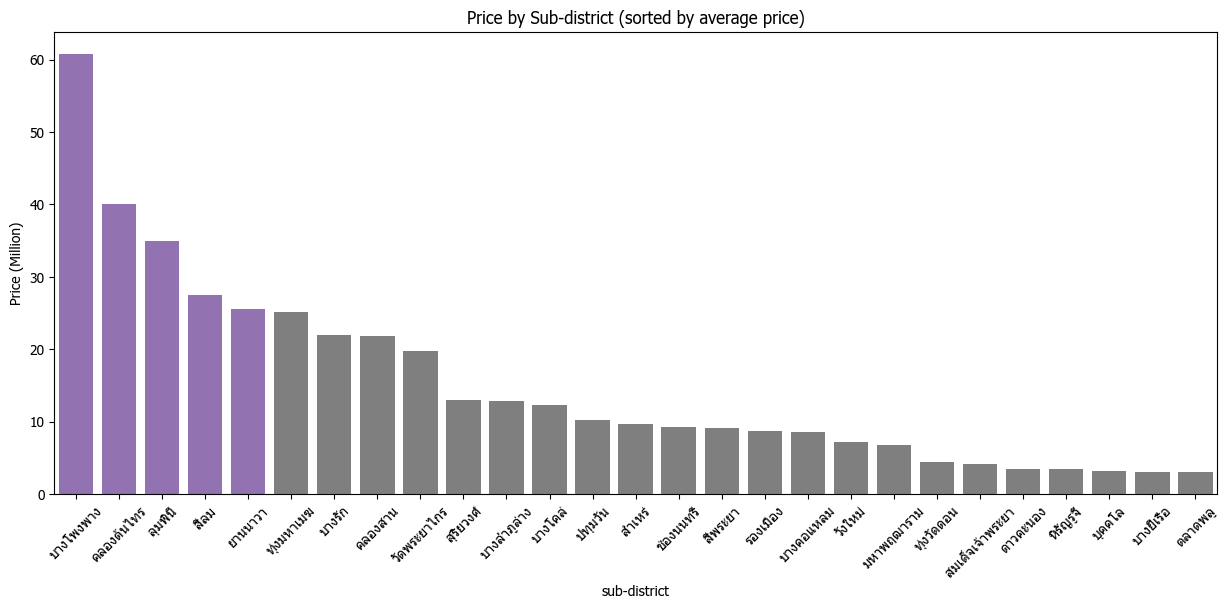

In [16]:
avg_price_by_sub_district = df.groupby('sub-district')['price'].mean().sort_values(ascending=False)

# create barplot with sorted order
plt.figure(figsize=(15,6))
color = ['tab:purple' if i < 5 else 'tab:grey' for i in range(len(df))]
sns.barplot(x=df['sub-district'], y=df['price']/1e6, order=avg_price_by_sub_district.index, errorbar=None, palette = color)
plt.title('Price by Sub-district (sorted by average price)')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.ylabel("Price (Million)")
plt.show()

<div style="border-radius:10px; border:#800080 solid; padding: 10px; background-color: #c8a2c8; font-size:100%; font-family:Times_New_Roman; text-align:left">

<h3 align="left"><font color='black'>Insights</font></h3>

<font color='black'>

จากกราฟที่ได้สร้างขึ้นจะสามารถดูได้ว่า กราฟที่เป็นสีม่วงแสดงถึงแขวงที่มีราคาเฉลี่ยสูงที่สุดในเมือง โดยมีแขวงที่สูงสุดอยู่ที่บางโพงพาง ตามลำดับด้วยแขวงคลองต้นไทร ลุมพินี สีลม และยานนาวาตามลำดับ ซึ่งอาจแสดงถึงความเป็นพื้นที่ที่เป็นที่นิยมอยู่ในกลุ่มผู้ที่มีรายได้สูงและความชื้นชอบที่จะอาศัยในพื้นที่เมืองที่เป็นศูนย์กลางของธุรกิจและกิจกรรมสังคม โดยผู้ที่ต้องการอาศัยในแขวงเหล่านี้จะต้องมีความพร้อมทางการเงินที่สูงมากกว่าแขวงอื่นๆ เนื่องจากราคาที่จะต้องจ่ายในการซื้อหรือเช่าที่อยู่อาศัยในพื้นที่นี้จะสูงกว่า

</font>

<a id="2.3"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid"> 2.3 Pointplot Price distribution for district</p>

การสร้างกราฟจุด (Pointplot) แสดงการกระจายตัวของราคาในแต่ละปีของเขตที่เลือก จากนั้นจึงนำผลลัพธ์ที่ได้จากกราฟมาวิเคราะห์และใช้เป็นข้อมูลในการตัดสินใจเลือกเขตที่เหมาะสมต่อการอาศัย โดยจะเลือกดูข้อมูลราคาในแต่ละปี เพื่อดูแนวโน้มของราคาในเขตนั้นๆ และหากมีการเปลี่ยนแปลงราคาในปีหนึ่งๆ จะได้ทราบเหตุผลว่าเกิดจากสาเหตุอะไร ซึ่งข้อมูลดังกล่าวจะช่วยให้ผู้วิเคราะห์เข้าใจราคาในแต่ละเขตและปีได้มากขึ้น และสามารถตัดสินใจเลือกเขตที่เหมาะสมกับความต้องการของตนเองได้ง่ายขึ้นด้วย

In [17]:
sub_district_names = df["sub-district"].unique()


In [18]:
@interact(Sub_District=sub_district_names)
def price_year(Sub_District='ลุมพินี'):
    plt.figure(figsize=(10,5))
    graph = df[df['sub-district'].isin([Sub_District])]

    year_data = graph[["year", "price"]].dropna() # drop NaN values and assign the returned DataFrame to year_data

    year_data['year'] = year_data['year'].apply(lambda x: '{:.0f}'.format(x))

    sns.pointplot(x=year_data["year"].astype(int), y=year_data['price'], color='teal', errorbar=None)
    plt.title(f'Price distribution for {Sub_District}')
    plt.xticks(rotation=45)

    ax = plt.gca()

    def y_axis_numformat(y, pos):
        return "{:,.0f}".format(y)
    plt.ylim(0, None)

    # Apply the formatter to the y-axis
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_axis_numformat))
    plt.show();

interactive(children=(Dropdown(description='Sub_District', index=16, options=('บางคอแหลม', 'บางโคล่', 'วัดพระย…

<div style="border-radius:10px; border:#800080 solid; padding: 10px; background-color: #c8a2c8; font-size:100%; font-family:Times_New_Roman; text-align:left">

<h3 align="left"><font color='black'>Insights</font></h3>

<font color='black'>

* การเปลี่ยนแปลงของราคาคอนโด อาจเกิดจากปัจจัยหลายประการ เช่น การเปลี่ยนแปลงของเศรษฐกิจ การเปลี่ยนแปลงในการพัฒนาที่ดินในพื้นที่ การเปลี่ยนแปลงในแนวโน้มการซื้อขาย การตัดสินใจของนักลงทุน การเปลี่ยนแปลงในนโยบายของรัฐ แต่มีปัจจัยหนึ่งที่ทำให้ราคาของสินค้าเพิ่มขึ้นได้แก่ "เงินเฟ้อ" ดังนั้นแล้วเมื่อเรามองเป็นภาพใหญ่ หรือที่เรียกว่า "Overview and Trend" จะพบว่าราคาอสังหาริมทรัพย์ประเภทคอนโดมิเนียมในเขตที่ศึกษาอยู่มีแนวโน้มของราคาที่สูงขึ้น

</font>

<a id="2.4"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid "> 2.4 Histogram plot </p>

เราสามารถพิจารณาข้อมูลแต่ละตัวแปรว่ามีการกระจายตัวแบบไหน โดยจะสังเกตได้จากการพล็อตข้อมูลเป็นช่วงค่า และความถี่ของค่าในแต่ละช่วง ซึ่งสามารถสรุปข้อมูลพื้นฐานของแต่ละตัวแปรได้อย่างง่ายดาย และเป็นการตรวจสอบความสมดุลของข้อมูลว่ามีค่าที่ผิดปกติหรือไม่ ช่วยให้เราตัดสินใจเลือกใช้โมเดลในการทำนายและวิเคราะห์ต่อไปได้อย่างถูกต้อง

In [19]:
plot_column = df[['price','bedroom','bathroom', 'space', 'year', 'floor', 'distance']]
# plot_column

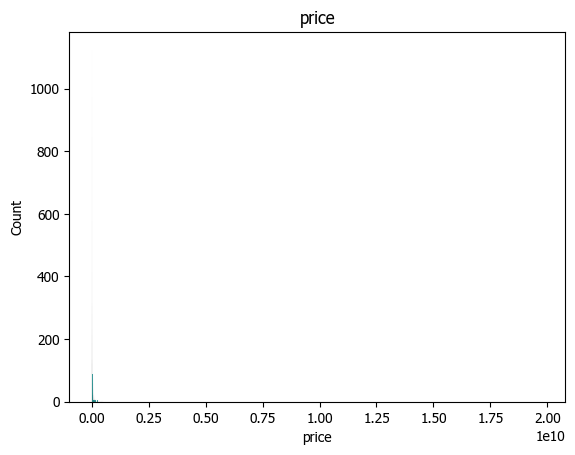

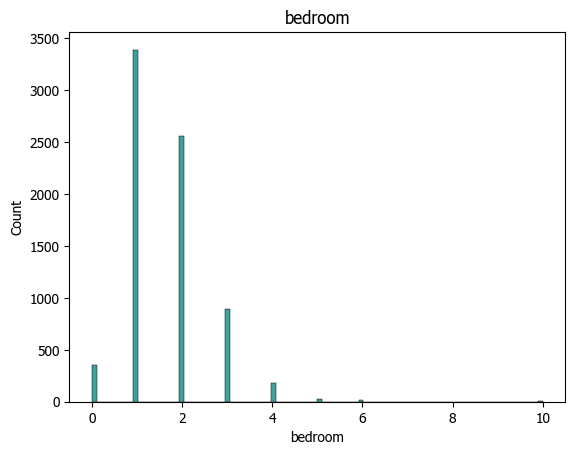

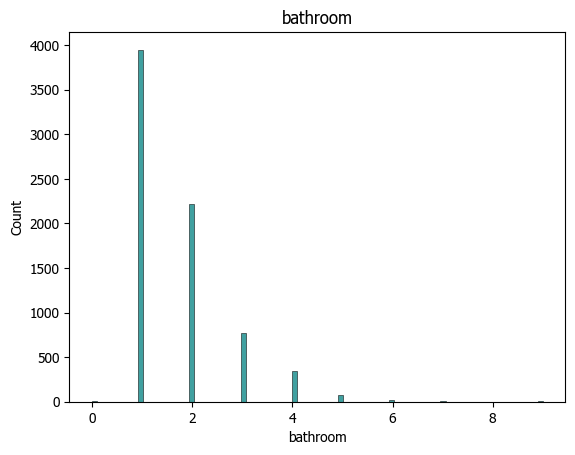

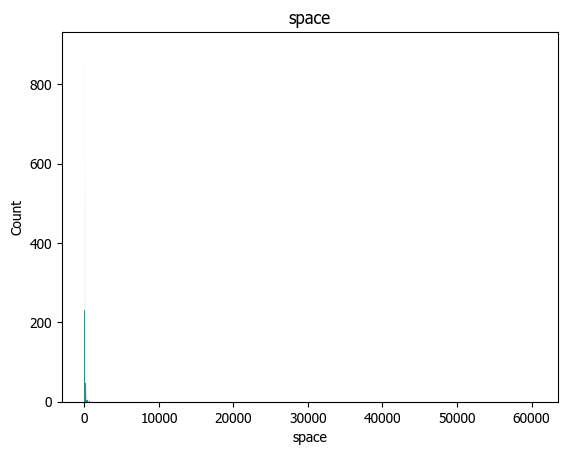

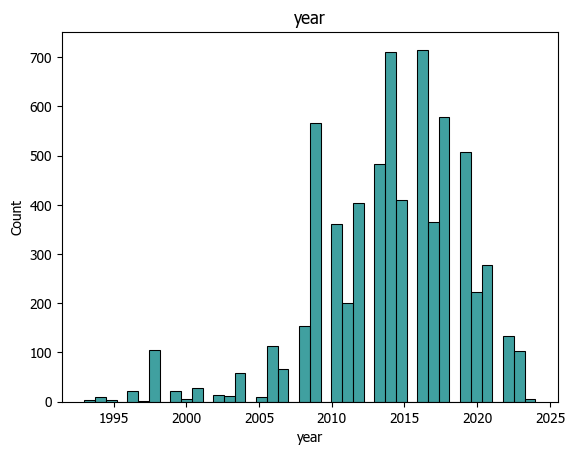

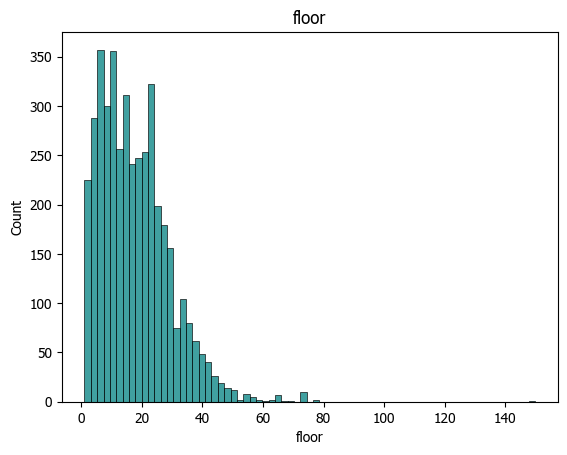

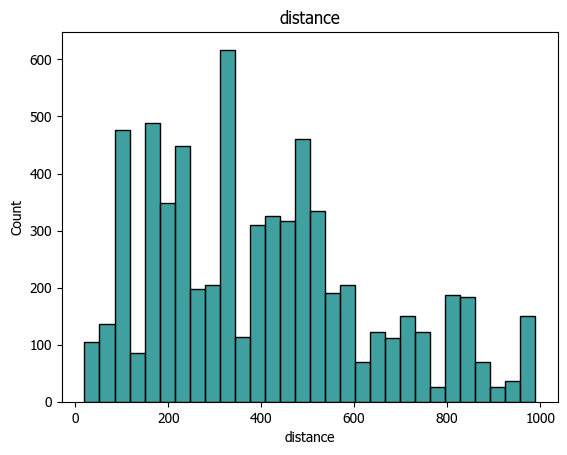

In [20]:
for plots in plot_column.columns:
    sns.histplot(df[plots], color='teal')
    plt.title(f'{plots}')
    plt.show()

<div style="border-radius:10px; border:#800080 solid; padding: 10px; background-color: #c8a2c8; font-size:100%; font-family:Times_New_Roman; text-align:left">

<h3 align="left"><font color='black'>Insights</font></h3>

<font color='black'>

- Column ที่เรานำมาวิเคราะห์ข้อมูลมีดังนี้ 
    * Price
    * Bedroom
    * Bathroom
    * Space 
    * Year 
    * Floor
    * Distance 
- โดย Features ต่างๆ เหล่านี้จะเป็นแกน X และในแกน Y จะแสดงจำนวนครั้งที่ข้อมูลในแต่ละช่วงของข้อมูลที่ตกลง ซึ่งจะถูก Represent ผ่านแท่งใน bin ต่างๆ อันแสดงถึงช่วงของข้อมูล
- มีแค่ column year เท่านั้นที่หลังจากทำการ histogram plot ได้มีข้อมูลเป็นเบ้ซ้าย อาจจะเพราะด้วยธุรกิจประเภทคอนโดเป็นที่นิยมมากขึ้นในแต่ละปี และมีแนวโน้มจะเพิ่มมากขึ้นอีกในปีต่อ ๆ ไป

</font>

<a id="2.5"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid"> 2.5 Pairplot </p>

Pair Plot ของข้อมูลที่สนใจ ซึ่งจะแสดงความสัมพันธ์ระหว่าง features ต่าง ๆ ในรูปแบบของ scatter plot โดยจะแสดงผลของแต่ละ feature ที่เลือกในแนวตั้งและแนวนอน และจะแสดงความสัมพันธ์ระหว่าง features ที่สนใจ หากความสัมพันธ์เป็นเชิงเส้นกันแน่ จะมีแนวโน้มที่จะมีจุดกระจายแบบเป็นเส้นตรง แต่หากเป็นเชิงโค้ง จะมีการกระจายที่แตกต่างกันและอาจแสดงความสัมพันธ์ที่ซับซ้อนขึ้น

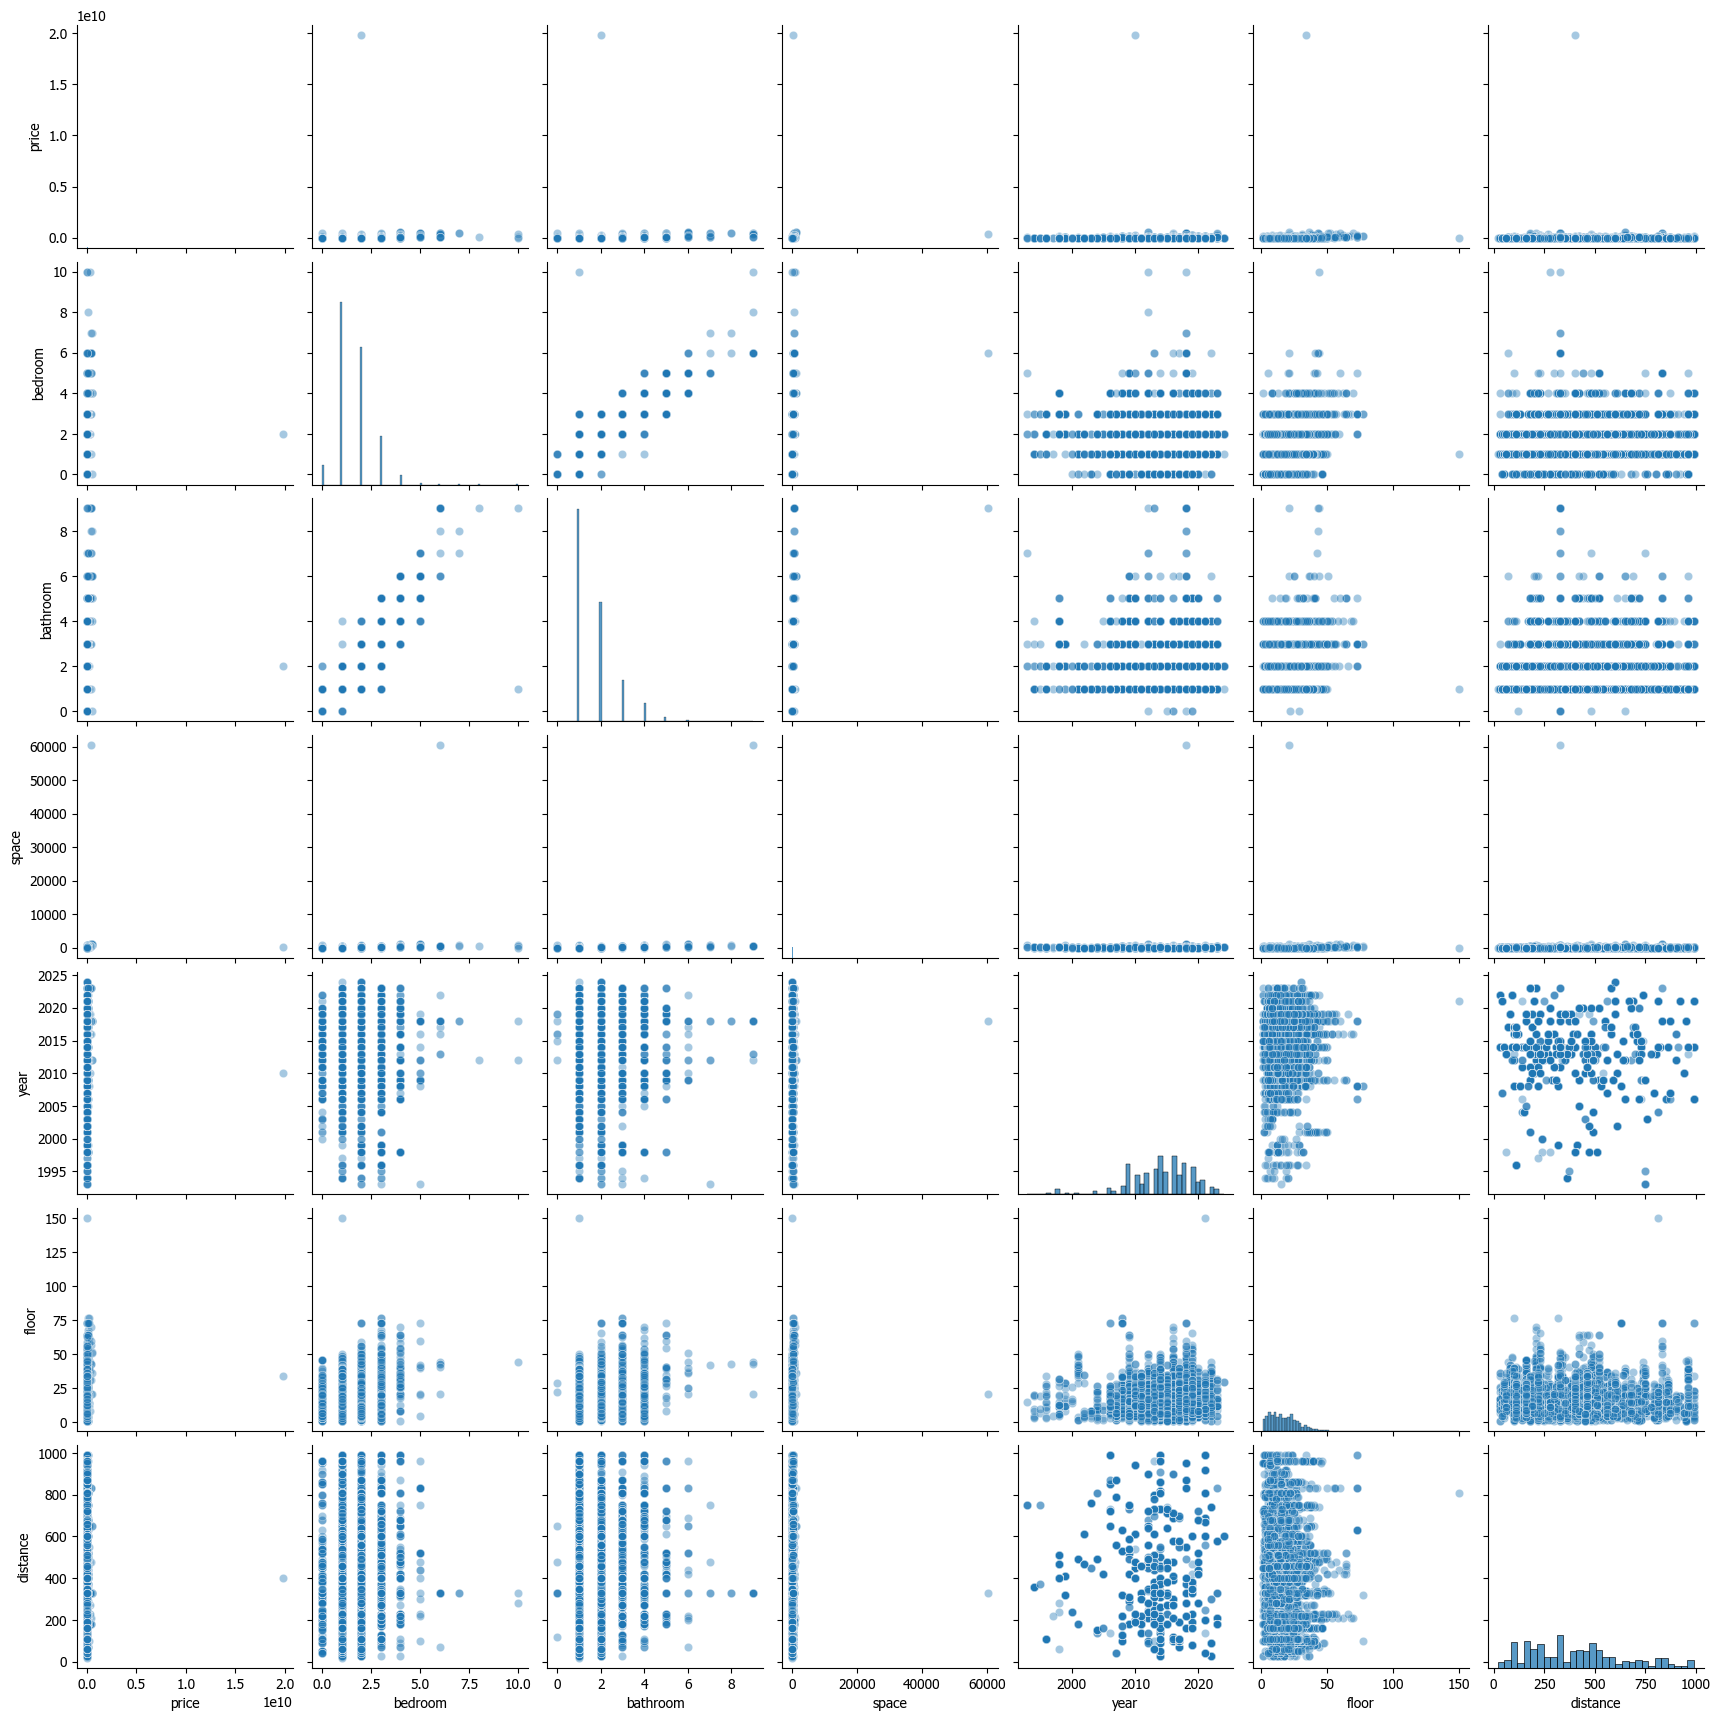

<Figure size 640x480 with 0 Axes>

In [21]:
sns.pairplot(plot_column, vars=['price','bedroom','bathroom', 'space', 'year', 'floor', 'distance'], 
             plot_kws={'alpha': .4})
plt.show();
plt.clf();

In [22]:
rows = [312, 313, 1022, 1374, 2461, 3462, 3463, 3465, 3466, 3797, 6529, 6447, 925, 1931, 2461, 2744, 2745, 3210, 3221, 3331, 4557, 5428, 2822, 2897, 4092, 4269, 4354, 4413, 4591, 5175, 5191, 5527, 5594, 5628, 4564, 2662, 7076]
df = df.drop(index=rows)

<div style="border-radius:10px; border:#800080 solid; padding: 10px; background-color: #c8a2c8; font-size:100%; font-family:Times_New_Roman; text-align:left">

<h3 align="left"><font color='black'>Insights</font></h3>

<font color='black'>

- หลังจาก pairplot เสร็จแล้ว อาจจะมีการตรวจสอบข้อมูลและพบว่ามี outliers หรือข้อมูลที่ผิดปกติที่อาจจะมีผลกระทบต่อการวิเคราะห์และสรุปข้อมูล ดังนั้นเพื่อให้ผลการวิเคราะห์และสรุปข้อมูลมีความถูกต้องและน่าเชื่อถือมากขึ้น

* Outliers
    * จำนวนชั้นที่ไม่ตรงกับความเป็นจริง (floor)
    * Space (พื้นที่ในห้อง)
    * Price (ราคา)
* Potentially Wrong
    * จำนวนชั้นที่ไม่ตรงกับความเป็นจริง (floor)
        - Chatrium Residence Riverside (research = 36 floors, data = 73 floors)
        - The Infinity Sathon (research = 40 floors, data = 77 floors)
        - The Station Sathon Bangrak, Four Seasons Private Residences and etc.
* Dedicated Finding
    * Space and Bedroom Mismatch
    * Wrong listing price

</font>

<a id="3"></a>
# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#00917C; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> 3. Data preparation</p>

ในขั้นตอน Data Preparation นั้น เราจะทำการเตรียมข้อมูลให้พร้อมสำหรับการนำไปใช้ในการวิเคราะห์ โดยเราจะทำการตรวจสอบและแก้ไขข้อมูลที่ไม่ถูกต้องหรือขาดหายไป เช่น การลบข้อมูลที่ซ้ำกัน การแก้ไขข้อมูลที่หายไป การแปลงข้อมูลให้อยู่ในรูปแบบที่เหมาะสมกับการวิเคราะห์ เช่น การเปลี่ยนข้อมูลจากข้อความเป็นตัวเลข การกำหนดชื่อและตัวแปรให้เหมาะสม ซึ่งการทำ Data Preparation เป็นขั้นตอนสำคัญที่ช่วยให้ผลการวิเคราะห์มีความน่าเชื่อถือและแม่นยำมากยิ่งขึ้น


<a id="3.1"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid"> 3.1 โดยกำหนด LabelEncoder ( เป็น order )</p>

`ตกแต่งครบ =  2`

`มีบางส่วน  =   1`

`ไม่มี        = 0`

In [23]:
df['furniture'].unique()

array([nan, 'ตกแต่งครบ', 'มีบางส่วน', 'ไม่มี'], dtype=object)

In [24]:
furniture = {'ตกแต่งครบ' : 2, 'มีบางส่วน' : 1, 'ไม่มี' : 0}

df['furniture_encoded'] = df['furniture'].map(furniture)
df = df.drop('furniture', axis =1 )
df.head(5)


,name,price,sub-district,bedroom,bathroom,space,year,type,floor,distance,station_id,is_Security,is_Laundry,is_Parking_Lot,is_Bus_Stop,is_Cleaning,is_Fitness,is_Convenient_Store,is_Balcony,is_View,is_Sport_Facility,is_Pool,is_Park,is_Garden,is_corner_room,furniture_encoded
0,Supalai Casa Riva,17500000.0,บางคอแหลม,3.0,3.0,240.0,2006.0,ขายขาด,NaN,720.0,B11,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN
1,Supalai Casa Riva,19000000.0,บางคอแหลม,3.0,3.0,230.0,2006.0,ขายขาด,NaN,720.0,B11,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN
2,Lumpini Place Rama 3 - Riverview,2500000.0,บางโคล่,1.0,1.0,39.0,2004.0,NaN,NaN,150.0,B10,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN
3,Lumpini Place Rama 3 - Riverview,3100000.0,บางโคล่,1.0,1.0,40.0,2004.0,NaN,NaN,150.0,B10,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN
4,Lumpini Place Rama 3 - Riverview,28500000.0,บางโคล่,1.0,1.0,39.0,2004.0,NaN,NaN,150.0,B10,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN


<a id="3.2"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid"> 3.2 Change categorical column to one-hot encoding </p>

การทำ One-hot encoding เป็นเทคนิดที่ใช้ในการจัดการข้อมูลก่อนนำไปสร้าง Model ซึ่งโดยปกติแล้วโมเดล machine learning ไม่สามารถประมวลผลข้อมูลที่เป็น categorical ได้โดยตรง เนื่องจากโมเดลนั้นทำงานโดยการคำนวณค่าตัวเลข ดังนั้นจึงต้องแปลงข้อมูลที่เป็น categorical เป็นรูปแบบของตัวเลขก่อนจึงนำไปสร้างโมเดล machine learning

One-hot encoding มีหลักการคือ การนำข้อมูลที่เป็น Categorical มาสร้างเป็นคอลัมน์ใหม่สำหรับแต่ละค่าในตัวแปร categorical แล้วกำหนดให้มีค่าเป็น 1 หรือ 0 ตามลำดับ โดยที่ 1 จะอยู่ที่ตำแหน่งของค่านั้น และ 0 จะเป็นค่าอื่น ๆ ทั้งหมด

ในที่นี้ Feature ที่เราแบ่งมาทำเป็น One-hot encoding คือ District, Type และ Station_id  

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7441 entries, 0 to 7476
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 7432 non-null   object 
 1   price                7433 non-null   float64
 2   sub-district         7441 non-null   object 
 3   bedroom              7388 non-null   float64
 4   bathroom             7366 non-null   float64
 5   space                7438 non-null   float64
 6   year                 6638 non-null   float64
 7   type                 6639 non-null   object 
 8   floor                4192 non-null   float64
 9   distance             6580 non-null   float64
 10  station_id           6580 non-null   object 
 11  is_Security          7441 non-null   bool   
 12  is_Laundry           7441 non-null   bool   
 13  is_Parking_Lot       7441 non-null   bool   
 14  is_Bus_Stop          7441 non-null   bool   
 15  is_Cleaning          7441 non-null   b

In [26]:
category_column = ['type','station_id']

In [27]:
df_dummy = pd.get_dummies(df['sub-district'], prefix='แขวง',prefix_sep='' ,drop_first=True)
df = pd.merge(df, df_dummy, left_index=True, right_index=True , how = "inner")
df = df.drop('sub-district', axis = 1)

In [28]:
for col in category_column:
    df_dummy = pd.get_dummies(df[col], drop_first=True)
    df = pd.merge(df, df_dummy, left_index=True, right_index=True , how = "inner")
    df = df.drop(col, axis = 1)

In [29]:
df.head()

,name,price,bedroom,bathroom,space,year,floor,distance,is_Security,is_Laundry,is_Parking_Lot,is_Bus_Stop,is_Cleaning,is_Fitness,is_Convenient_Store,is_Balcony,is_View,is_Sport_Facility,is_Pool,is_Park,is_Garden,is_corner_room,furniture_encoded,แขวงคลองสาน,แขวงช่องนนทรี,แขวงดาวคะนอง,แขวงตลาดพลู,แขวงทุ่งมหาเมฆ,แขวงทุ่งวัดดอน,แขวงบางคอแหลม,แขวงบางยี่เรือ,แขวงบางรัก,แขวงบางลำภูล่าง,แขวงบางโคล่,แขวงบางโพงพาง,แขวงบุคคโล,แขวงปทุมวัน,แขวงมหาพฤฒาราม,แขวงยานนาวา,แขวงรองเมือง,แขวงลุมพินี,แขวงวังใหม่,แขวงวัดพระยาไกร,แขวงสมเด็จเจ้าพระยา,แขวงสำเหร่,แขวงสีลม,แขวงสี่พระยา,แขวงสุริยวงศ์,แขวงหิรัญรูจี,เช่าซื้อระยะยาว 30 ปี,เช่าระยะยาว,B10,B11,B12,B2,B3,B4,B5,B6,B7,B8,B9,BL24,BL25,BL26,BL27,BL28,BL30,E1,E14,E2,E3,G2,G3,RN07,S1,S10,S11,S2,S3,S4,S5,S6,S7,S8,S9,W1
0,Supalai Casa Riva,17500000.0,3.0,3.0,240.0,2006.0,NaN,720.0,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Supalai Casa Riva,19000000.0,3.0,3.0,230.0,2006.0,NaN,720.0,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Lumpini Place Rama 3 - Riverview,2500000.0,1.0,1.0,39.0,2004.0,NaN,150.0,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Lumpini Place Rama 3 - Riverview,3100000.0,1.0,1.0,40.0,2004.0,NaN,150.0,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Lumpini Place Rama 3 - Riverview,28500000.0,1.0,1.0,39.0,2004.0,NaN,150.0,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
df.columns

Index(['name', 'price', 'bedroom', 'bathroom', 'space', 'year', 'floor',
       'distance', 'is_Security', 'is_Laundry', 'is_Parking_Lot',
       'is_Bus_Stop', 'is_Cleaning', 'is_Fitness', 'is_Convenient_Store',
       'is_Balcony', 'is_View', 'is_Sport_Facility', 'is_Pool', 'is_Park',
       'is_Garden', 'is_corner_room', 'furniture_encoded', 'แขวงคลองสาน',
       'แขวงช่องนนทรี', 'แขวงดาวคะนอง', 'แขวงตลาดพลู', 'แขวงทุ่งมหาเมฆ',
       'แขวงทุ่งวัดดอน', 'แขวงบางคอแหลม', 'แขวงบางยี่เรือ', 'แขวงบางรัก',
       'แขวงบางลำภูล่าง', 'แขวงบางโคล่', 'แขวงบางโพงพาง', 'แขวงบุคคโล',
       'แขวงปทุมวัน', 'แขวงมหาพฤฒาราม', 'แขวงยานนาวา', 'แขวงรองเมือง',
       'แขวงลุมพินี', 'แขวงวังใหม่', 'แขวงวัดพระยาไกร', 'แขวงสมเด็จเจ้าพระยา',
       'แขวงสำเหร่', 'แขวงสีลม', 'แขวงสี่พระยา', 'แขวงสุริยวงศ์',
       'แขวงหิรัญรูจี', 'เช่าซื้อระยะยาว 30 ปี', 'เช่าระยะยาว', 'B10', 'B11',
       'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'BL24', 'BL25',
       'BL26', 'BL27', 'BL28', 'BL30', 'E1', 'E

<a id="4"></a>
# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#00917C; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> 4. Models </p>

**Model** คือ สิ่งที่ใช้สร้างความสัมพันธ์ระหว่างข้อมูลเข้า (Input data) และผลลัพธ์ที่ต้องการ (Output)  โดยใช้อัลกอริทึมเพื่อเรียนรู้และนำไปใช้ประโยชน์ต่อในอนาคต ซึ่งการสร้าง Model ใน Machine Learning จะเริ่มต้นด้วยการคัดเลือก Algorithm ที่สำคัญและเหมาะสมกับปัญหาที่ต้องการแก้ไข หลังจากนั้นจะนำข้อมูลมาแบ่งเป็น 2 ส่วนคือ  Training set และ Test set 

    - Training set : การนำข้อมูลจริงที่มีอยู่แล้วมาใส่เป็นตัวอย่างเพื่อให้เครื่องเรียนรู้ ซึ่งในการ train อาจะมีการปรับเปลี่ยน parameter ของ Algorithm เพื่อให้ model ที่ได้มีประสิทธิภาพและความแม่นยำสูงสุด โดยใช้วิธีการประมาณค่าความคลาดเคลื่อนระหว่างค่าที่คำนวณได้จาก Model กับค่าจริง (Error) และนำไปปรับปรุง Model ให้มีค่า Error น้อยลง
    - Test set : เมื่อ Model ได้รับการ Train เสร็จแล้ว จึงจะนำ Model มาทดสอบด้วยข้อมูลที่ไม่เคยเห็นมาก่อน (Test Data / Unseen Data) เพื่อวัดความแม่นยำของ Model ว่าสามารถทำนายผลลัพธ์ได้ถูกต้องเท่าใด

หลังจากได้ Model ที่มีประสิทธิภาพและมีความแม่นยำสูงสุดแล้ว จะนำข้อมูลที่ได้จากการทำ Model ไปใช้ในการทำนาย (Prediction) ของข้อมูลใหม่ที่มาถึง 



In [31]:
df['price'].dropna(inplace=True)
df.dropna(subset=['price'], inplace=True)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7433 entries, 0 to 7476
Data columns (total 87 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   7424 non-null   object 
 1   price                  7433 non-null   float64
 2   bedroom                7383 non-null   float64
 3   bathroom               7361 non-null   float64
 4   space                  7432 non-null   float64
 5   year                   6631 non-null   float64
 6   floor                  4187 non-null   float64
 7   distance               6573 non-null   float64
 8   is_Security            7433 non-null   bool   
 9   is_Laundry             7433 non-null   bool   
 10  is_Parking_Lot         7433 non-null   bool   
 11  is_Bus_Stop            7433 non-null   bool   
 12  is_Cleaning            7433 non-null   bool   
 13  is_Fitness             7433 non-null   bool   
 14  is_Convenient_Store    7433 non-null   bool   
 15  is_B

<a id="4.1"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid"> 4.1 Spilt train test </p>

In [33]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = ['price', 'name'])
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

<a id="4.3"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000;text-align:left; padding:10px; border-bottom: 3px solid "> 4.2 Create and Find best Models </p>

หลังจากทำโมเดล เราสามารถนำมาประเมินโดยหาความแม่นยำว่าโมเดลที่ได้ มีความแม่นยำ (score/R2 score) เท่าไหร่การทำนายข้อมูล รวมทั้งแสดง ค่าคลาดเคลื่อน (error) ของการทำนาย ซึ่งในที่นี้เราจะใช้ Mean squared error และ root mean squared error เป็นตัววัด 

    MSE หรือ mean square error คือค่าเฉลี่ยของตารางค่าความคลาดเคลื่อนของโมเดล โดยค่าความคลาดเคลื่อนแต่ละค่าจะถูกยกกำลังสองแล้วหารด้วยจำนวนข้อมูลทั้งหมด เป็นตัววัดที่ใช้บ่อยที่สุดในการประเมินความแม่นยำของโมเดล

    RMSE หรือ root mean squared error จะเป็นรูปแบบการคำนวณค่าคลาดเคลื่อนเดียวกับ MSE แต่จะทำการหา square root ของ MSE เพื่อให้ได้ค่าที่แสดงถึงความคลาดเคลื่อนเป็นหน่วยเดียวกับค่าที่เราพิจารณา (yi) ซึ่ง RMSE จะให้ผลลัพธ์เป็นหน่วยเดียวกับข้อมูลที่เราพิจารณา จึงมีประโยชน์ในการเปรียบเทียบความแม่นยำของโมเดลในชุดข้อมูลที่มีหน่วยของตัวแปรต่างกัน

การหา Error ใน Machine Learning Model จะช่วยให้ผู้ใช้งานสามารถปรับปรุงโมเดลได้อย่างเหมาะสม เช่น การปรับแต่ง Hyperparameters หรือเลือกโมเดลที่เหมาะสมกับปัญหา โดยการลด Error จะหมายถึงการปรับโมเดลให้มีความแม่นยำมากขึ้นและเข้าใกล้ค่าผลลัพธ์จริงมากขึ้น

In [41]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [42]:
def display_model_score(model):

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    print("-"*50)
    print(model.__class__.__name__)
    print("-"*50)
    print(f"Coefficient of Determination")
    print(f"train score : {model.score(X_train, y_train)}")
    print(f"test  score : {model.score(X_test, y_test)}")
    print("-"*50)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", sqrt(mse))
    print("-"*50)

<a id="4.3"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid"> 4.3 Feature Important </p>

การหา Feature Importance เป็นการวิเคราะห์ว่าแต่ละ Feature ในข้อมูลมีผลกระทบต่อผลลัพธ์ของโมเดล Machine Learning อย่างไร ซึ่งจะช่วยให้ผู้ใช้งานสามารถเข้าใจได้ว่า Feature ใดบ้างที่สำคัญและมีผลต่อผลลัพธ์ของโมเดลมากที่สุด ผู้ใช้งานสามารถนำ Feature นั้นมาใช้ในการ Train Model อย่างเฉพาะเจาะจง หรือลบ Feature ที่ไม่สำคัญออกจากข้อมูลได้ ซึ่งจะช่วยให้ผู้ใช้งานสามารถดำเนินการปรับปรุงและพัฒนาโมเดลได้อย่างมีประสิทธิภาพมากขึ้น


In [36]:
def display_important_feature(models):
    importances = models.feature_importances_
    indices = np.argsort(importances)
    features = X.columns
    plt.figure(figsize=(15, 15))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='#2DC6BA', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')

    for i, v in enumerate(importances[indices]):
        plt.text(v + 0.01, i, f"{v:.2f}", fontsize=8)

    plt.show()


<a id="4.4"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid"> 4.4 Compare Predict vs Actual </p>

แสดงค่าที่ได้จากการทำนาย เปรียบเทียบกับข้อมูลที่เป็น Unseen data (Test Data) ว่าผลการทำนายจากโมเดลที่ได้กับข้อมูลที่เกิดขึ้นจริงคลาดเคลื่อนมากน้อยเท่าไหร่

In [37]:
def display_pridict_vs_actual(model): 
    y_pred = model.predict(X_test)
    x_ax = range(len(y_test))
    plt.figure(figsize=(15, 6))
    plt.plot(x_ax, y_test, label="original",alpha=0.5, color='teal' )
    plt.plot(x_ax, y_pred, label="predicted",alpha=0.5, color='purple')
    plt.title("dataset test and predicted data")
    plt.xlabel('X')
    plt.ylabel('Price')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show()  

<a id="4.5"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid"> 4.5 Create Model </p>

สำหรับ Dataset นี้ เราได้เลือก Model ที่นำมาเปรียบเทียบทั้งหมด 3 Model ได้แก่ 

1. Light GBM (Light Gradient Boosting)

    * ข้อดี 
        1. มีความรวดเร็วในการ train model เนื่องจากเป็นการใช้ parallel computing
           
        2. มีประสิทธิภาพการทำนายได้มากกว่า Model อื่นเมื่อต้องเจอกับข้อมูลที่มีขนาดใหญ่ และจำนวนมาก

        3. ไม่ต้องทำ Feature Scaling ก่อนเพราะสามารถรองรับ Imbalanced data ได้
        
    * ข้อเสีย
        1. ไม่เหมาะสมกับการจัดการข้อมูลที่มีขนาดเล็ก เนื่องจากอาจทำให้เกิดปัญหา overfitting ได้


2. XGBoost (Extreme Gradient Boosting)

    * ข้อดี 
        1. มีความรวดเร็วในการ train model เนื่องจากเป็นการใช้ parallel computing
        
        2. สามารถ Train Model ได้กับข้อมูลที่มีจำนวน Feature มาก และ Sample น้อย โดยไม่เกิด overfitting 

        3. สามารถจัดการกับ Missing Values ได้ดี
    * ข้อเสีย
    
        1. ต้องกำหนดจำนวน Hyperparameters มาก และถ้ากำหนดไม่เหมาะสม อาจทำให้โมเดลไม่มีประสิทธิภาพได้
        
        2. อาจใช้เวลานานในการ Train Model ในข้อมูลที่มีจำนวน Feature มาก และมีขนาดใหญ่

3. Catboost (Gradient Boosting with Categorical feature support)

    * ข้อดี 
        1. มีความรวดเร็วในการ train model เนื่องจาก เป็นการใช้ parallel computing
        
        2. สามารถ Train Model ได้กับข้อมูลที่มีจำนวน Sample น้อย
        3. สามารถจัดการกับข้อมูลที่มีความซับซ้อนสูง และมีจำนวน Feature มากได้ดี
    * ข้อเสีย

        1. อาจใช้เวลา Train Model นานกว่า Algorithm อื่น ๆ เช่น XGBoost หรือ LightGBM
        
        2. ไม่สามารถรองรับ Imbalanced Data ได้จึงจำเป็นต้องทำ Feature Selection ก่อนที่จะ Train Model
        3. ต้องกำหนดจำนวน Hyperparameters มาก และถ้ากำหนดไม่เหมาะสม อาจทำให้โมเดลไม่มีประสิทธิภาพได้



<a id="4.5"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid"> 4.5.1 LightGBM Regressor </p>

In [38]:
from lightgbm import LGBMRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
import lightgbm as lgb

In [ ]:
lgbm = LGBMRegressor(max_bin=400,
    num_leaves=75,
    learning_rate=0.1,
    n_estimators= 300,
    verbose= -1)

lgbm.fit(X_train, y_train)


In [43]:
display_model_score(lgbm)

--------------------------------------------------
LGBMRegressor
--------------------------------------------------
Coefficient of Determination
train score : 0.9864102912086841
test  score : 0.9153721792805082
--------------------------------------------------
Mean Squared Error: 169116637041227.72
Root Mean Squared Error: 13004485.266292846
--------------------------------------------------


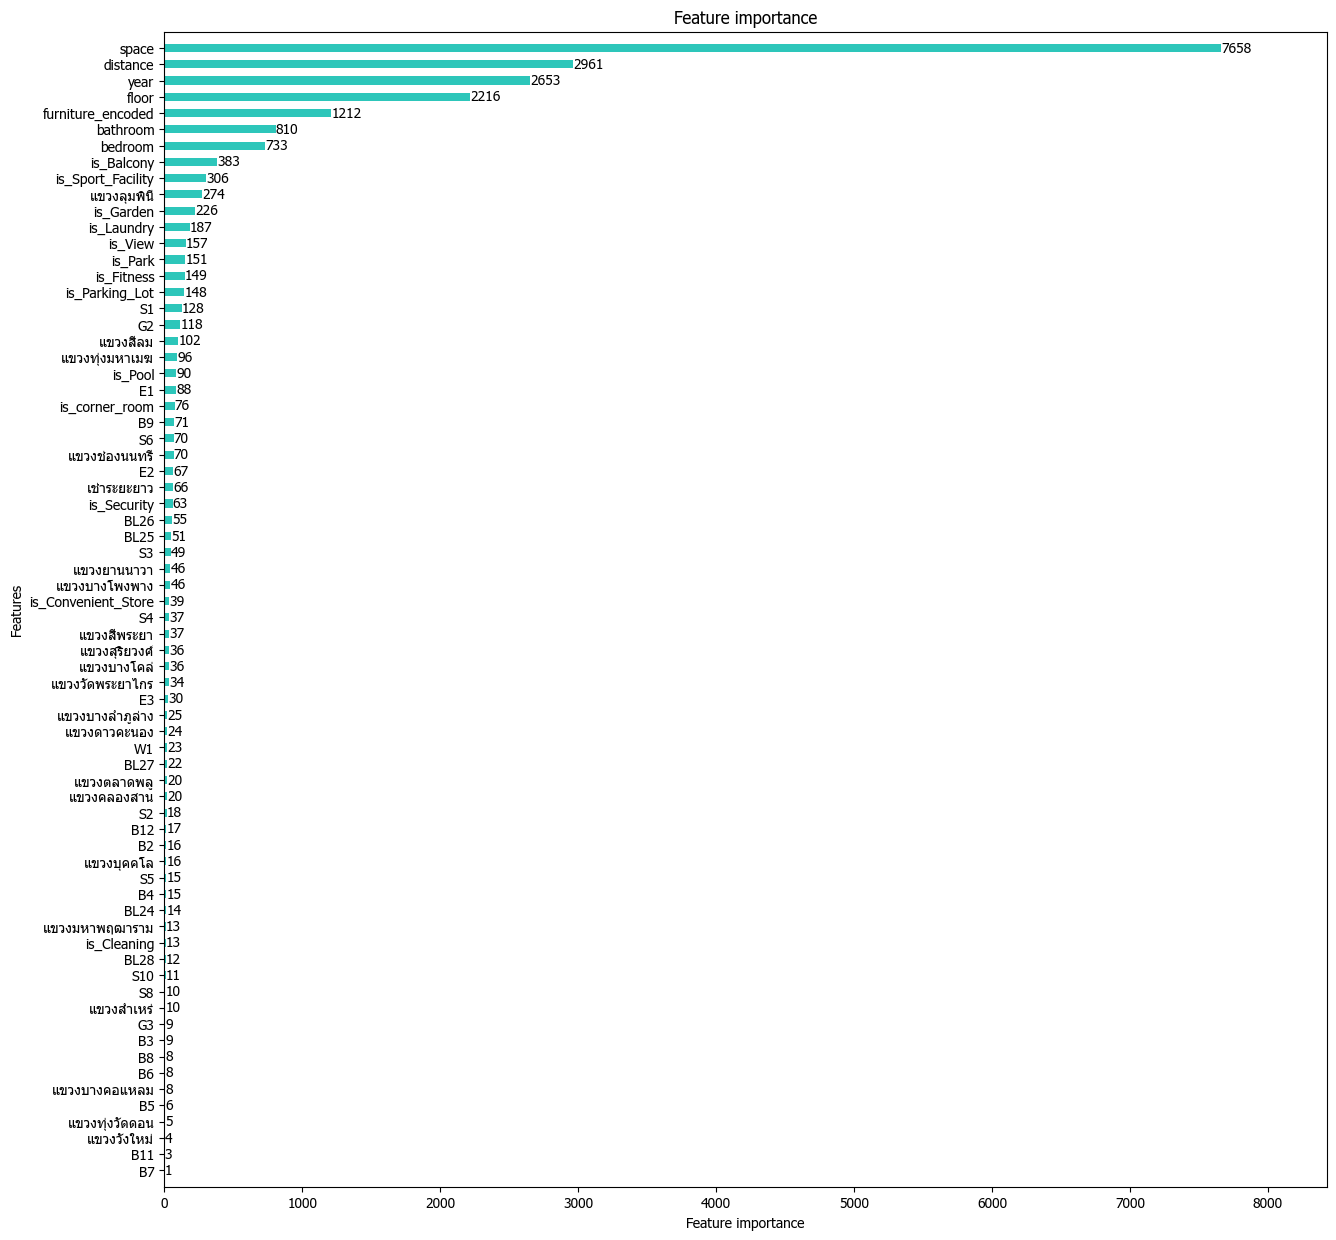

In [44]:
fig, ax = plt.subplots(figsize=(15, 15))
lgb.plot_importance(lgbm, height=0.5, ax=ax , grid=False, color = '#2DC6BA');

<a id="4.5"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid"> 4.5.2 XGBoost Regressor </p>

In [45]:
import xgboost as xgb
from xgboost import XGBRegressor

In [46]:
xgbr = XGBRegressor(
            n_estimators=300, max_depth=6, learning_rate=0.2
            )

xgbr.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [47]:
display_model_score(xgbr)

--------------------------------------------------
XGBRegressor
--------------------------------------------------
Coefficient of Determination
train score : 0.9980655563309777
test  score : 0.9334089624883493
--------------------------------------------------
Mean Squared Error: 133072696724456.69
Root Mean Squared Error: 11535713.966827398
--------------------------------------------------


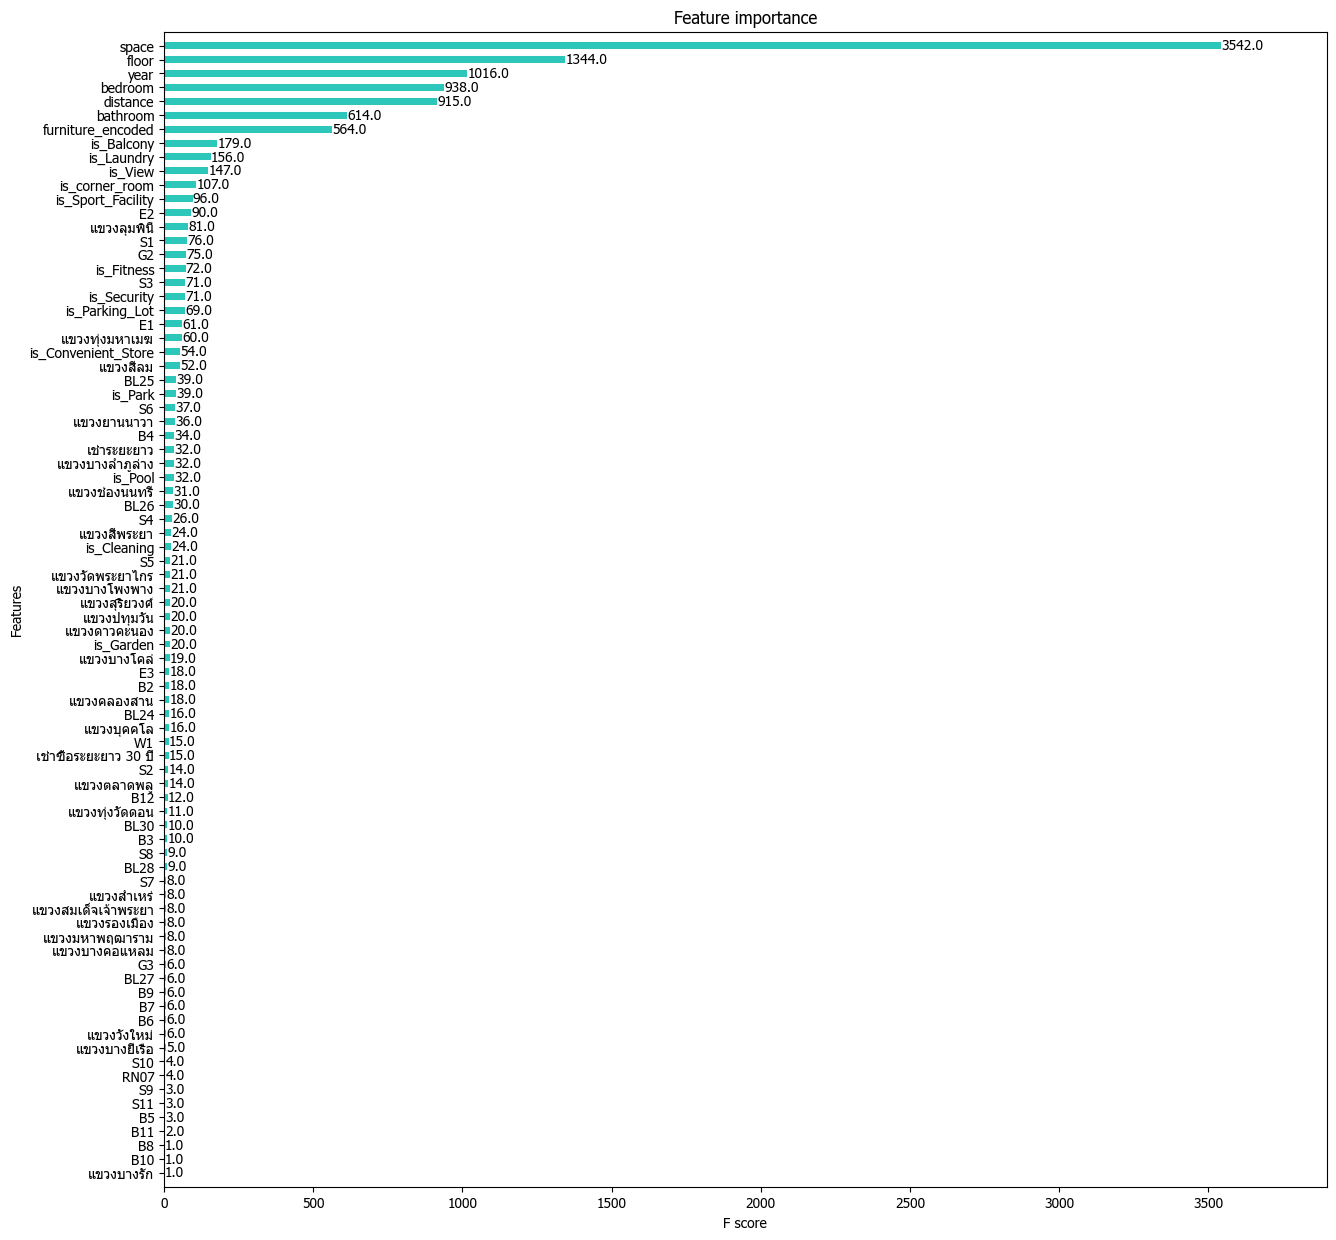

In [48]:
fig, ax = plt.subplots(figsize=(15, 15))
xgb.plot_importance(xgbr, height=0.5, ax=ax, grid=False, color = '#2DC6BA');

<a id="4.5"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid"> 4.5.3 CatBoost Regressor </p>

In [49]:
import catboost as cb
from catboost import CatBoostRegressor

In [50]:
cbr = CatBoostRegressor(
                    n_estimators=100
                    , max_depth=10
                    , learning_rate=0.1
                    , loss_function= 'RMSE' )

cbr.fit(X_train, y_train)


0:	learn: 35294781.8754607	total: 157ms	remaining: 15.5s
1:	learn: 33003698.5833866	total: 169ms	remaining: 8.28s
2:	learn: 31107149.5013148	total: 180ms	remaining: 5.83s
3:	learn: 29234978.1815881	total: 195ms	remaining: 4.69s
4:	learn: 27417346.8517259	total: 208ms	remaining: 3.94s
5:	learn: 25820574.5026844	total: 222ms	remaining: 3.48s
6:	learn: 24352090.7919388	total: 236ms	remaining: 3.13s
7:	learn: 23034395.9095375	total: 248ms	remaining: 2.85s
8:	learn: 21741806.5907336	total: 262ms	remaining: 2.65s
9:	learn: 20624537.6571280	total: 274ms	remaining: 2.47s
10:	learn: 19782800.7795862	total: 285ms	remaining: 2.31s
11:	learn: 18868559.8287106	total: 297ms	remaining: 2.18s
12:	learn: 17997147.0549627	total: 309ms	remaining: 2.06s
13:	learn: 17200972.7890871	total: 319ms	remaining: 1.96s
14:	learn: 16500067.3908529	total: 330ms	remaining: 1.87s
15:	learn: 15739516.8741188	total: 341ms	remaining: 1.79s
16:	learn: 15057692.3047859	total: 352ms	remaining: 1.72s
17:	learn: 14427074.2292

--------------------------------------------------
CatBoostRegressor
--------------------------------------------------
Coefficient of Determination
train score : 0.9834381210799185
test  score : 0.9071832946121061
--------------------------------------------------
Mean Squared Error: 185480955825105.44
Root Mean Squared Error: 13619139.320276646
--------------------------------------------------


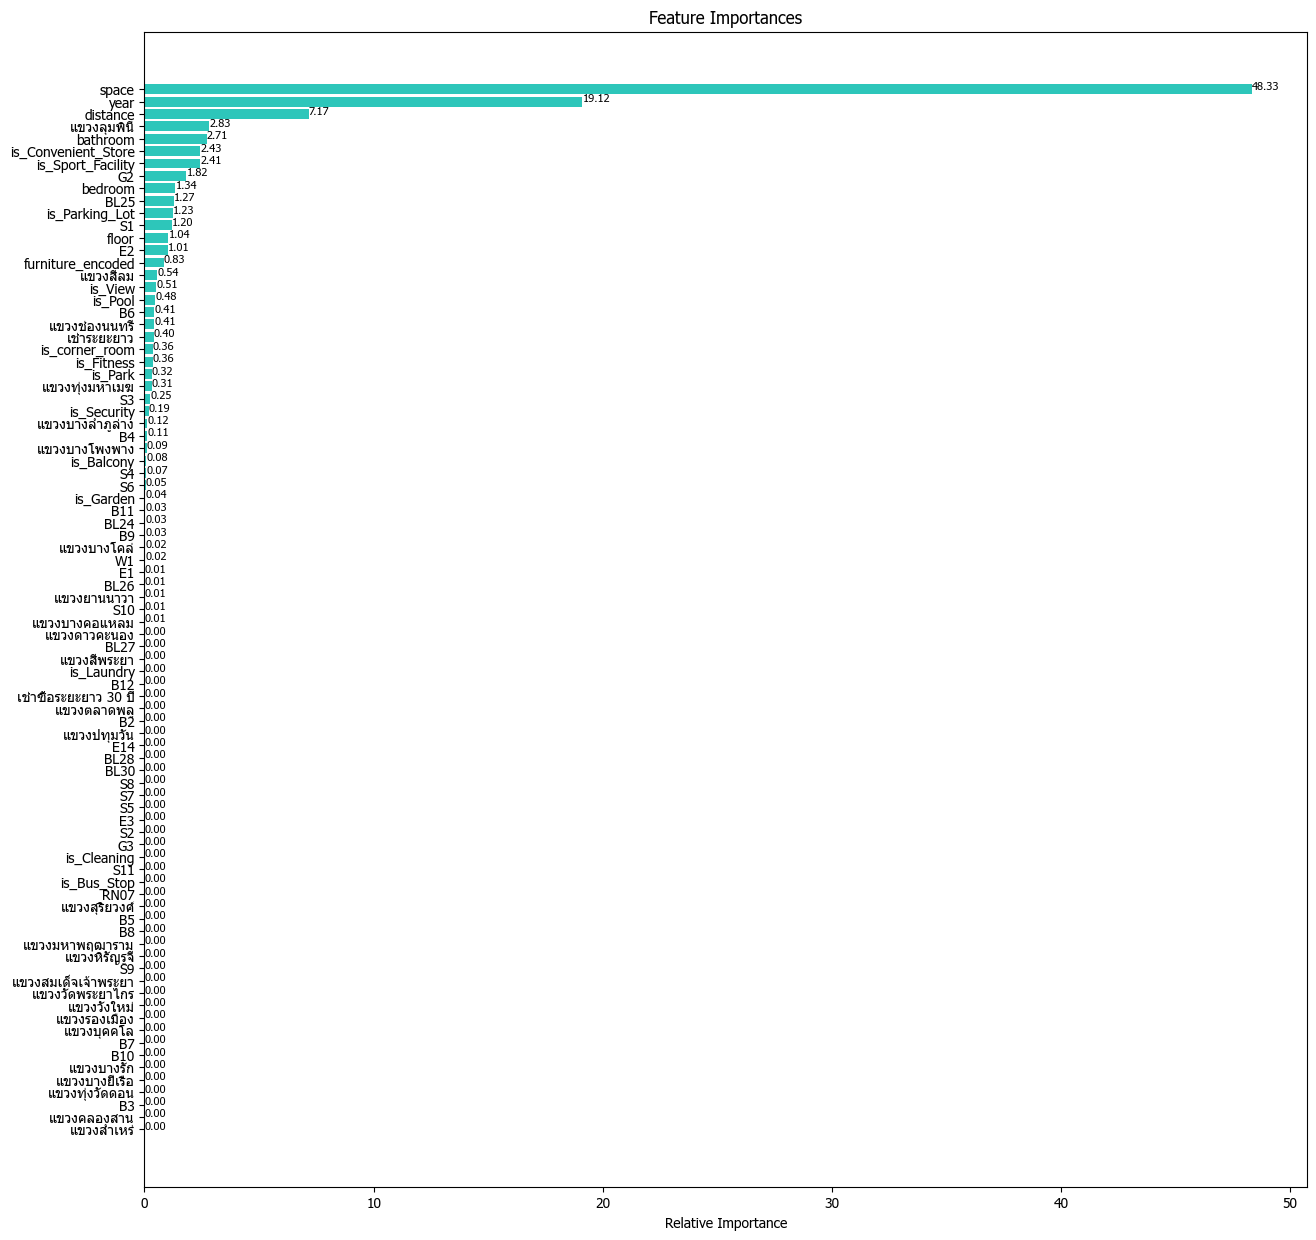

In [51]:
display_model_score(cbr)
display_important_feature(cbr)

<a id="4"></a>
# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#00917C; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> 5. Feature and Model Evaluation </p>

In [52]:
df.columns

Index(['name', 'price', 'bedroom', 'bathroom', 'space', 'year', 'floor',
       'distance', 'is_Security', 'is_Laundry', 'is_Parking_Lot',
       'is_Bus_Stop', 'is_Cleaning', 'is_Fitness', 'is_Convenient_Store',
       'is_Balcony', 'is_View', 'is_Sport_Facility', 'is_Pool', 'is_Park',
       'is_Garden', 'is_corner_room', 'furniture_encoded', 'แขวงคลองสาน',
       'แขวงช่องนนทรี', 'แขวงดาวคะนอง', 'แขวงตลาดพลู', 'แขวงทุ่งมหาเมฆ',
       'แขวงทุ่งวัดดอน', 'แขวงบางคอแหลม', 'แขวงบางยี่เรือ', 'แขวงบางรัก',
       'แขวงบางลำภูล่าง', 'แขวงบางโคล่', 'แขวงบางโพงพาง', 'แขวงบุคคโล',
       'แขวงปทุมวัน', 'แขวงมหาพฤฒาราม', 'แขวงยานนาวา', 'แขวงรองเมือง',
       'แขวงลุมพินี', 'แขวงวังใหม่', 'แขวงวัดพระยาไกร', 'แขวงสมเด็จเจ้าพระยา',
       'แขวงสำเหร่', 'แขวงสีลม', 'แขวงสี่พระยา', 'แขวงสุริยวงศ์',
       'แขวงหิรัญรูจี', 'เช่าซื้อระยะยาว 30 ปี', 'เช่าระยะยาว', 'B10', 'B11',
       'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'BL24', 'BL25',
       'BL26', 'BL27', 'BL28', 'BL30', 'E1', 'E

จากที่กล่าวข้างต้นว่า การหา Feature Importance ทำให้เรารู้ว่า Feature ใดที่สำคัญและส่งผลกับโมเดล หลังจากที่ทำโมเดลรอบแรกโดยใช้ Feature ทั้งหมดเสร็จแล้ว <br>

เราจึงสามารถตัด Feature ที่ไม่จำเป็นออก (Feature Reduction) เพื่อนำมาพัฒนาโมเดลที่เรามีอยู่ให้ดียิ่งขึ้นได้ จะสังเกตได้ว่า feature หลักๆ ที่ส่งผลต่อโมเดลมีดังนี้

1. space

2. year
3. distance
4. แขวงลุมพินี
5. bathroom
6. bedroom
7. floor
8. furniture_encoded
9. is_Parking_Lot

คณะผู้จัดทำจึงนำเพียง 9 feature ที่สำคัญนี้มาใส่กลับเข้าไปอีกครั้งเพื่อทำการปรับปรุงโมเดลอีกครั้ง

In [53]:
X = df[['space','year','distance','แขวงลุมพินี','bathroom','bedroom','floor','furniture_encoded','is_Parking_Lot']]
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

<a id="4.4"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid">  LightGBM Regressor </p>

In [54]:
lgbr = LGBMRegressor(max_bin=400,
    num_leaves=75,
    learning_rate=0.1,
    n_estimators= 300,
    verbose= -1)

lgbr.fit(X_train, y_train)

LGBMRegressor(max_bin=400, n_estimators=300, num_leaves=75, verbose=-1)

In [55]:
display_model_score(lgbr)

--------------------------------------------------
LGBMRegressor
--------------------------------------------------
Coefficient of Determination
train score : 0.9859971976018919
test  score : 0.9457357011427516
--------------------------------------------------
Mean Squared Error: 60387774691368.93
Root Mean Squared Error: 7770957.128396021
--------------------------------------------------


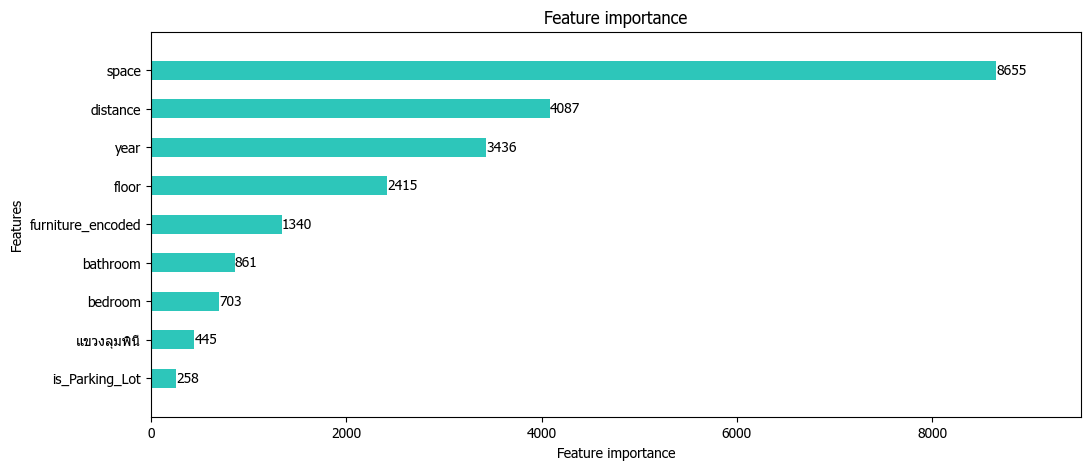

In [56]:
fig, ax = plt.subplots(figsize=(12, 5))
lgb.plot_importance(lgbr, height=0.5, ax=ax, grid=False, color = '#2DC6BA')
plt.show()

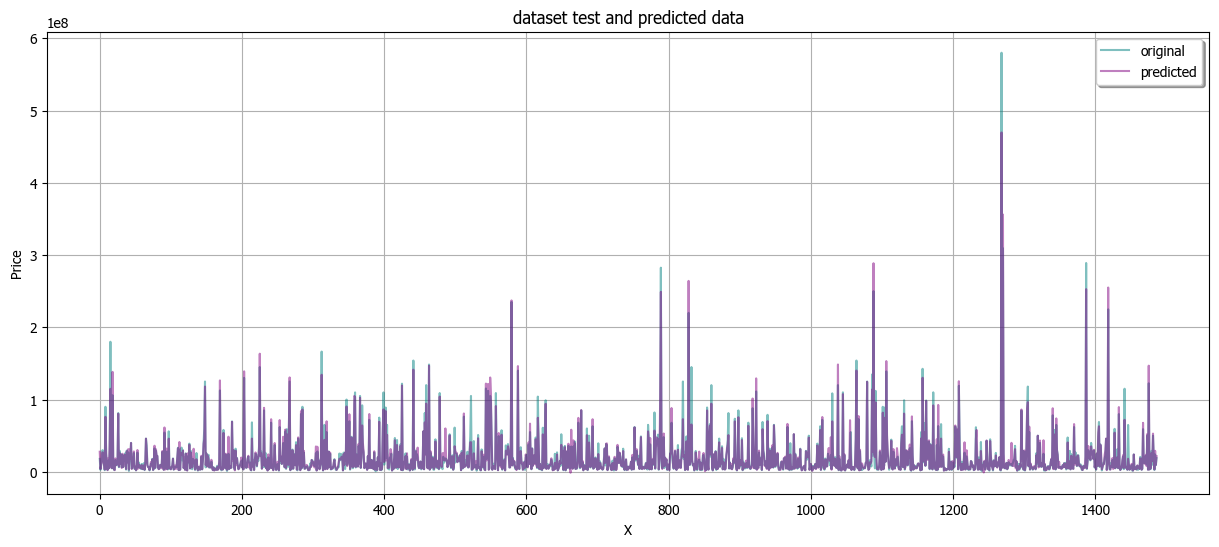

In [57]:
display_pridict_vs_actual(lgbr)

<a id="4.4"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid">  XGBoost Regressor </p>

In [58]:
xgbr = XGBRegressor(
            n_estimators=300
            , max_depth=6
            , learning_rate=0.2
            )

xgbr.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [59]:
display_model_score(xgbr)

--------------------------------------------------
XGBRegressor
--------------------------------------------------
Coefficient of Determination
train score : 0.9963905779570055
test  score : 0.9572156895099562
--------------------------------------------------
Mean Squared Error: 47612322587915.07
Root Mean Squared Error: 6900168.301419544
--------------------------------------------------


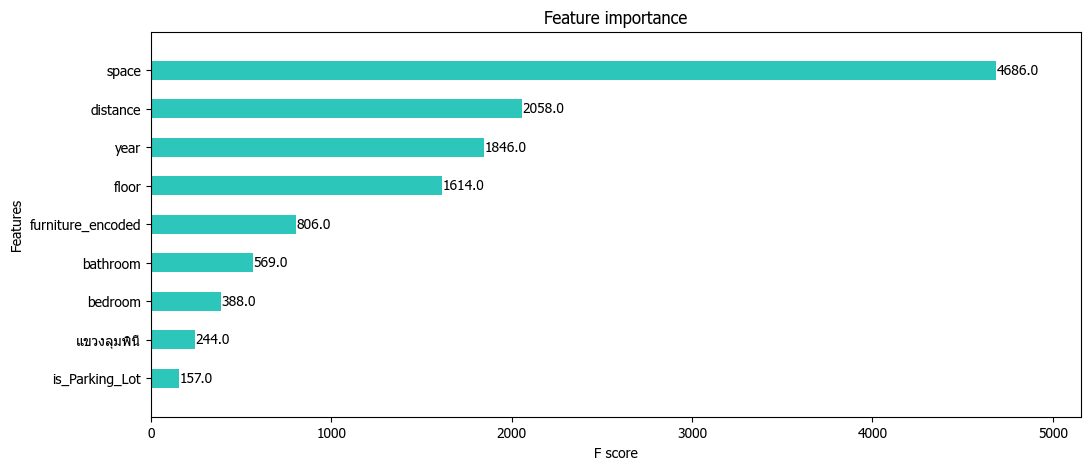

In [60]:
fig, ax = plt.subplots(figsize=(12, 5))
xgb.plot_importance(xgbr, height=0.5, ax=ax, grid=False, color = '#2DC6BA')
plt.show()

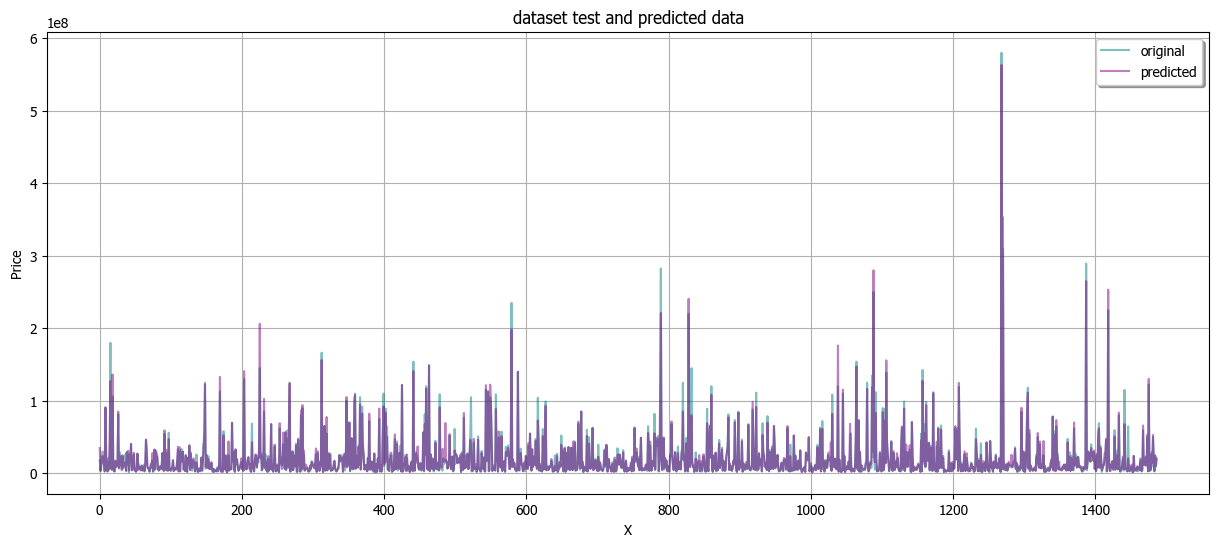

In [61]:
display_pridict_vs_actual(xgbr)

<a id="4.4"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid">  Catboost Regressor </p>

In [62]:
cbr = CatBoostRegressor(
                    n_estimators=100
                    , max_depth=5
                    , learning_rate=0.1
                    , loss_function= 'RMSE' )

cbr.fit(X_train, y_train)

0:	learn: 38049479.4982279	total: 41.8ms	remaining: 4.14s
1:	learn: 35575707.8176400	total: 43.3ms	remaining: 2.12s
2:	learn: 33272515.8883748	total: 44.4ms	remaining: 1.44s
3:	learn: 31338482.8059089	total: 45.5ms	remaining: 1.09s
4:	learn: 29485596.2121594	total: 46.6ms	remaining: 885ms
5:	learn: 27846446.6897628	total: 47.7ms	remaining: 747ms
6:	learn: 26349787.7254705	total: 48.7ms	remaining: 648ms
7:	learn: 25007436.9726842	total: 50.9ms	remaining: 586ms
8:	learn: 23813324.7719625	total: 52.7ms	remaining: 533ms
9:	learn: 22794758.7558673	total: 54.3ms	remaining: 489ms
10:	learn: 21815273.0628201	total: 57ms	remaining: 461ms
11:	learn: 20907606.8777683	total: 58.5ms	remaining: 429ms
12:	learn: 20067537.7299945	total: 60.1ms	remaining: 402ms
13:	learn: 19311295.1373639	total: 61.3ms	remaining: 376ms
14:	learn: 18721797.6260930	total: 62.9ms	remaining: 356ms
15:	learn: 18138592.0848829	total: 64.2ms	remaining: 337ms
16:	learn: 17662931.9688099	total: 65.5ms	remaining: 320ms
17:	learn

In [63]:
display_model_score(cbr)

--------------------------------------------------
CatBoostRegressor
--------------------------------------------------
Coefficient of Determination
train score : 0.9426351133081822
test  score : 0.9087583264382995
--------------------------------------------------
Mean Squared Error: 101537875574548.66
Root Mean Squared Error: 10076600.397681188
--------------------------------------------------


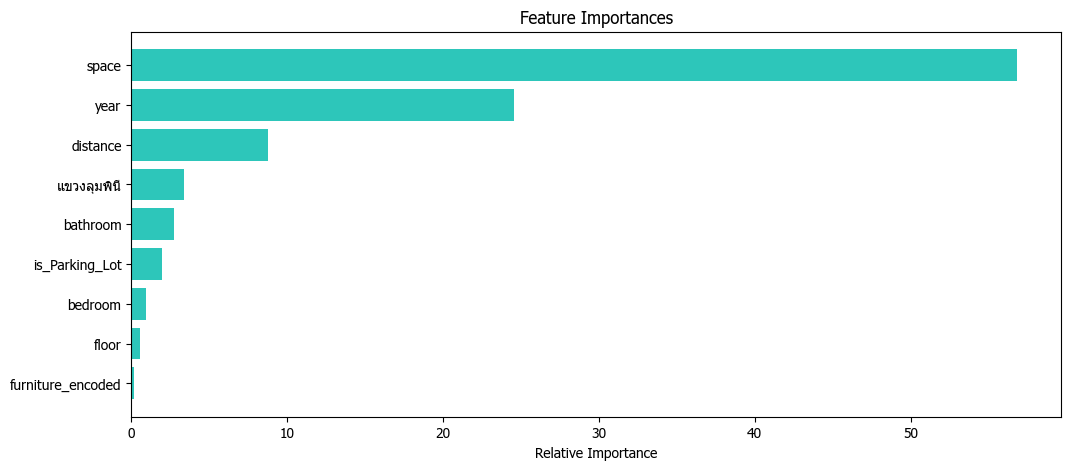

In [64]:
importances = cbr.feature_importances_
indices = np.argsort(importances)
features = X.columns
plt.figure(figsize=(12, 5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#2DC6BA', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

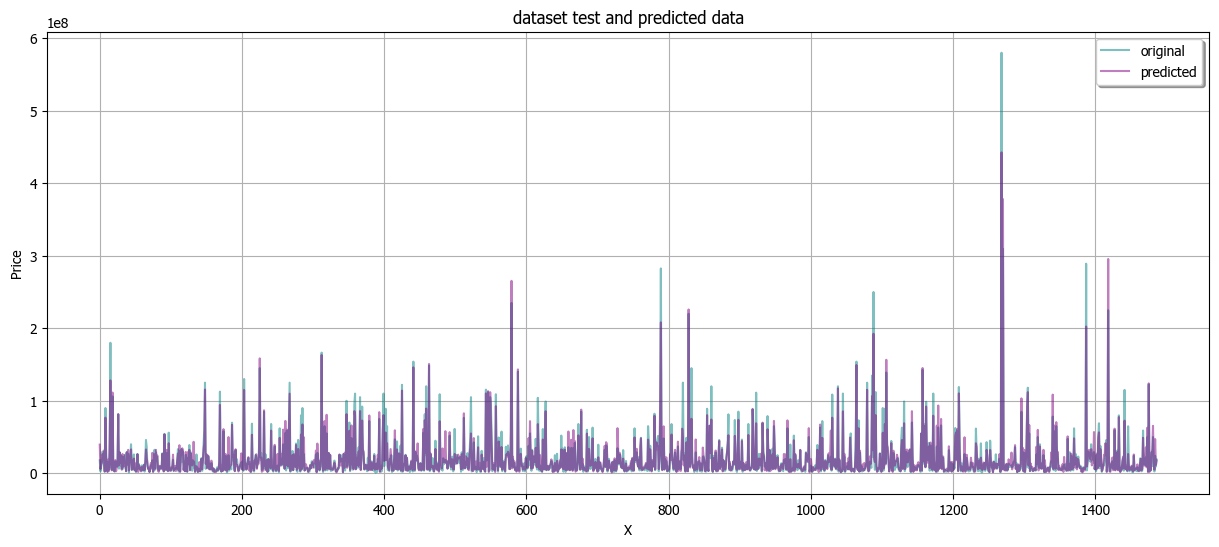

In [65]:
display_pridict_vs_actual(cbr)

<a id="6"></a>
# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#00917C; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> 6. Prediction </p>

คณะผู้จัดทำได้ scraped ข้อมูลทั้งหมดในการทำ Model ในวันที่ 9 เมษายน 2566 อย่างไรก็ดี เนื่องจากต้องการข้อมูลที่ใช้ในการ Predict จึงได้มีการดึงข้อมูลเพิ่มจากเว็บไซต์ เพื่อเป็นตัวอย่างในการวัด Performance ของ Model <br>

ผู้จัดทำได้ไปเก็บข้อมูลเพิ่มมาทั้งหมด 3 records (เพื่อใช้ในการทดสอบโดยเฉพาะ)
* Watermark Chaopraya River -> ราคา 42,000,000 บาท
* Wyne Sukhumvit -> ราคา 5,200,000 บาท
* Rhythm Sathorn -> ราคา 7,900,000 บาท

ในการเก็บข้อมูลเพิ่มเติมนี้นั้นเปรียบเสมือน Unseen data คือข้อมูลที่โมเดลไม่เคยเจอมาก่อน จึงนำข้อมูลเหล่านี้มาวัดประสิทธิภาพ 
> These records are not in our datasets nor training and validation set

In [67]:
feature = ['space','year','distance','แขวงลุมพินี','bathroom','bedroom','floor','furniture_encoded','is_Parking_Lot']

In [68]:
predict_data = [
    # Watermark Chaopraya River : วอร์เตอร์มาร์ค เจ้าพระยา, กรุงเทพ
       [285, 2012, np.nan, 0, 3, 3, 43, 2, 1],

    # Wyne Sukhumvit : วายน์ สุขุมวิท, กรุงเทพ
       [44, 2012, 420, 0, 1, 1, 25, 0, 1],
       
    # Rhythm Sathorn : ริทึ่ม สาทร, กรุงเทพ
       [45, 2015, 330, 0, 1, 1, 29, 2, 1]
       ] 

predict_df = pd.DataFrame(predict_data)
predict_df.columns = feature

In [69]:
places = np.array(['Watermark Chaopraya River : วอร์เตอร์มาร์ค เจ้าพระยา, กรุงเทพ'
                  , 'Wyne Sukhumvit : วายน์ สุขุมวิท, กรุงเทพ'
                  , 'Rhythm Sathorn : ริทึ่ม สาทร, กรุงเทพ'
                  ])

In [70]:
actuals = np.array([42000000, 5200000, 7900000])

In [71]:
result_lgb = lgbr.predict(predict_df)
result_xgb = xgbr.predict(predict_df)
result_cb = cbr.predict(predict_df)

In [72]:
for place, actual,r_lgm,r_xgb,r_cb in zip(places,actuals,result_lgb,result_xgb,result_cb):
    print(place)
    print(f"Actual Price             : {actual:,.0f} THB")
    print(f"Predicted Price LGBM     : {r_lgm:,.0f} THB")
    print(f"Predicted Price XGBoost  : {r_xgb:,.0f} THB")
    print(f"Predicted Price CatBoost : {r_cb:,.0f} THB \n")

Watermark Chaopraya River : วอร์เตอร์มาร์ค เจ้าพระยา, กรุงเทพ
Actual Price            : 42,000,000 THB
Predicted Price LGBM    : 43,008,043 THB
Predicted Price XGBoost : 42,136,612 THB
Predicted Price CatBoost: 46,424,209 THB 

Wyne Sukhumvit : วายน์ สุขุมวิท, กรุงเทพ
Actual Price            : 5,200,000 THB
Predicted Price LGBM    : 3,692,488 THB
Predicted Price XGBoost : 4,175,826 THB
Predicted Price CatBoost: 4,698,992 THB 

Rhythm Sathorn : ริทึ่ม สาทร, กรุงเทพ
Actual Price            : 7,900,000 THB
Predicted Price LGBM    : 7,765,286 THB
Predicted Price XGBoost : 7,472,882 THB
Predicted Price CatBoost: 5,981,994 THB 



<a id="5"></a>
# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#00917C; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> 7. Reference </p>
Scraping เพื่อดึงข้อมูลแต่ละคอนโดในแต่ละเขต วันที่ทำการเก็บข้อมูล 9 เมษายน 2566

Source:
- [Yannawa](https://www.ddproperty.com/รวมประกาศขาย?freetext=ยานนาวา&listing_type=sale&market=residential&property_type=N&district_code[]=TH1012&property_type_code[]=CONDO&search=true)
- [Bang Kho Laem](https://www.ddproperty.com/รวมประกาศขาย?freetext=บางคอแหลม&listing_type=sale&market=residential&property_type=N&district_code[]=TH1031&property_type_code[]=CONDO&search=true)
- [Thonburi](https://www.ddproperty.com/รวมประกาศขาย?freetext=ธนบุรี&listing_type=sale&market=residential&property_type=N&district_code[]=TH1015&property_type_code[]=CONDO&search=true)
- [Sathorn](https://www.ddproperty.com/รวมประกาศขาย?freetext=สาทร&listing_type=sale&market=residential&property_type=N&district_code[]=TH1028&property_type_code[]=CONDO&search=true)
- [Khlong San](https://www.ddproperty.com/รวมประกาศขาย?freetext=คลองสาน&listing_type=sale&market=residential&property_type=N&property_type_code[]=CONDO&district_code[]=TH1018&search=true)
- [Pathumwan](https://www.ddproperty.com/รวมประกาศขาย?freetext=ปทุมวัน&listing_type=sale&market=residential&property_type=N&property_type_code[]=CONDO&district_code[]=TH1007&search=true)
- [Bang Rak](https://www.ddproperty.com/รวมประกาศขาย?freetext=บางรัก&listing_type=sale&market=residential&property_type=N&property_type_code[]=CONDO&district_code[]=TH1004&search=true)
